<a href="https://colab.research.google.com/github/MarekSroka/Bank_Deposits/blob/main/working_copy_orig__Bank_deposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TREŚĆ ZADANIA**

W pliku Bank Marketing data.csv znajdują się dane charakteryzujące klientów pewnego banku oraz kampanie marketingowe skierowane do tych klientów. Dołączone są ponadto wskaźniki społeczne i ekonomiczne. Na podstawie tych danych należy zbudować model prognozujący szansę, że klient w wyniku prowadzonej kampanii założy lokatę terminową. Szczegółowy opis danych znajduje się w pliku Description.txt (opis jest w języku angielskim). Proszę się z nim zapoznać, gdyż zawiera ważne z punktu widzenia modelowania informacje.
Proszę o przesłanie raportu w którym opisana zostanie budowa modelu. Proszę zawrzeć w raporcie opis poszczególnych kroków prowadzących do powstania modelu.
Format pliku: pdf, word
Język raportu: polski lub angielski (nie ma to znaczenia dla oceny)

Title: Bank Marketing data (with social/economic context)

3. Time range: from May 3008 to November 2010

3. Attribute information:

   Input variables:
   # Bank client data:

   1 - age (numeric)

   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

   5 - default: has credit in default? (categorical: "no","yes","unknown")

   6 - housing: has housing loan? (categorical: "no","yes","unknown")

   7 - loan: has personal loan? (categorical: "no","yes","unknown")

   # Related with the last contact of the current campaign:

   8 - contact: contact communication type (categorical: "cellular","telephone")

   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

   # Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - previous: number of contacts performed before this campaign and for this client (numeric)

  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

   # Social and economic context attributes

  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

  17 - cons.price.idx: consumer price index - monthly indicator (numeric)
     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")


4. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label.


5. The goal is to assess the probability that the client will subscribe a bank term deposit (variable y).

# Import and install libraries \ notebook settings

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# pip install --upgrade pip
!pip install sweetviz
!pip install dtale
!pip install plotly
!pip install ppscore
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sts
import plotly.graph_objects as go

from google.colab import data_table
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import svm

from sklearn.base import is_classifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
# from sklearn.dummy import DummyClassifier

import eli5
from eli5.sklearn import PermutationImportance

#installed libraries
import sweetviz as sw
import dtale
import dtale.app as dtale_app
import plotly.graph_objs as go
import ppscore as pps


In [4]:
# !pip list

In [5]:
pd.set_option('display.max_columns', None)
data_table.enable_dataframe_formatter()

# Functions

In [7]:
# funkcja sprawedzjąca feature importance - dla modeli, dla których jest dostęp do klasyfikatora

def calculate_and_print_feature_importance(model, feature_names):
    if isinstance(model, Pipeline_imb):
        # Find the classifier step in the pipeline
        classifier_step = None
        for step_name, step in model.named_steps.items():
            if is_classifier(step):
                classifier_step = step
                break

        if classifier_step is not None:
            # Extract the coefficients from the classifier
            coefficients = classifier_step.coef_[0] if hasattr(classifier_step, 'coef_') else None

            if coefficients is not None:
                # Calculate the absolute values of the coefficients as feature importances
                feature_importances = np.abs(coefficients)

                # Combine feature names with their importances
                feature_importance_dict = dict(zip(feature_names, feature_importances))

                # Sort features by importance in descending order
                sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

                # Print or analyze the feature importances
                for feature, importance in sorted_feature_importance:
                    print(f"Feature: {feature}, Importance: {importance}")
            else:
                print("Coefficient information not available for the classifier.")
        else:
            print("Classifier not found in the pipeline.")
    elif hasattr(model, 'coef_'):
        # Extract the coefficients from the LogisticRegression model
        coefficients = model.coef_[0]

        # Calculate the absolute values of the coefficients as feature importances
        feature_importances = np.abs(coefficients)

        # Combine feature names with their importances
        feature_importance_dict = dict(zip(feature_names, feature_importances))

        # Sort features by importance in descending order
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Print or analyze the feature importances
        for feature, importance in sorted_feature_importance:
            print(f"Feature: {feature}, Importance: {importance}")
    else:
        print("Coefficient information not available for the model.")

In [8]:
# funkcja sprawedzjąca feature importance - dla modeli, dla nie ma dostępu do klasyfikatora

def calculate_and_print_feature_importance_2(model, X, y):
    # Utwórz obiekt PermutationImportance
    perm = PermutationImportance(model, random_state=seed)
    # Dopasuj model do danych
    perm.fit(X, y)

    # Wyświetl znaczenie cech
    feature_importance = eli5.explain_weights(perm, feature_names=X.columns.tolist(), top=None, target_names=["Outcome"])
    print(eli5.format_as_text(feature_importance))

In [9]:
# support functions for Using Label Encoder in the Pipeline

class LabelEncoderTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            le = LabelEncoder()
            X_copy[column] = le.fit_transform(X_copy[column])
        return X_copy

In [12]:
# bez plotowania AUC roc na 1 wykresie

metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

models = []

def calculation_metrics(model, model_name):
    global metrics_dataframe

    predictions = model.predict(X_test_data)
    predictions_proba = model.predict_proba(X_test_data)

    # Precision, Recall, F1
    print(classification_report(y_test_data, predictions))

    # ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba[:, 1])
    plt.plot(fpr, tpr, label=model_name)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print('======' * 20)

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test_data, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(f'\nConfusion matrix for {model_name}\n')
    plt.show()

    # AUC and F1 score

    f1score = f1_score(y_test_data, predictions)
    auc = roc_auc_score(y_test_data, predictions_proba[:, 1])

    metrics_dataframe = metrics_dataframe.append({'Model': model_name, 'F1_score': f1score, 'AUC': auc},
                                                 ignore_index=True)

    return metrics_dataframe



# Now, metrics_dataframe contains the metrics for all the models.


# Loading data

In [14]:
df = pd.read_csv('/content/gdrive/MyDrive/000.Projekt_KRD/Bank Marketing data.csv', delimiter=';', na_values=['unknown'])

# EDA


### Sweetviz library for EDA

In [15]:
# analyse_report = sw.analyze(df)

In [16]:
# analyse_report.show_html('df_start.html', open_browser=True)

In [17]:
# current_datetime = str(datetime.now().strftime("%Y_%m_%d_%H%M"))
# raport = analyse_report.show_html('total_df_' + current_datetime +'.html', open_browser=True)

### dtale library for EDA

In [18]:
# dtale_app.USE_COLAB = True

# dtale.show(df)

In [19]:
dtale.instances()

currently no running instances...


In [20]:
# dtale.get_instance(1).kill()

## Basic information and statistics

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4080 non-null   object 
 2   marital         4108 non-null   object 
 3   education       3952 non-null   object 
 4   default         3316 non-null   object 
 5   housing         4014 non-null   object 
 6   loan            4014 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [22]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [23]:
#ilość wierszy z wartością null w DF
df.isnull().sum()

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

##Columns Review

In [24]:
# age

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['age'])][['age']]
chart, labels = np.histogram(s['age'], bins=15)

kde = sts.gaussian_kde(s['age'])
kde_data = kde.pdf(np.linspace(labels.min(), labels.max()))
# main statistics
stats = df['age'].describe().to_frame().T
charts = [
	go.Bar(x=labels[1:], y=chart, name='Histogram'),
	go.Scatter(
		x=list(range(len(kde_data))), y=kde_data, name='KDE',		yaxis='y2', xaxis='x2',		line={'shape': 'spline', 'smoothing': 0.3}, mode='lines'
	)
]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'age Histogram (bins: 25) w/ KDE'},
    'xaxis2': {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    'yaxis': {'side': 'left', 'title': {'text': 'Frequency'}},
    'yaxis2': {'overlaying': 'y', 'side': 'right', 'title': {'text': 'KDE'}}
}))


figure.show()

In [25]:
#transform month and day of week into categorical data

month_order = ['jan', 'feb', 'mar', "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

day_order = ["mon","tue","wed","thu","fri"]

df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

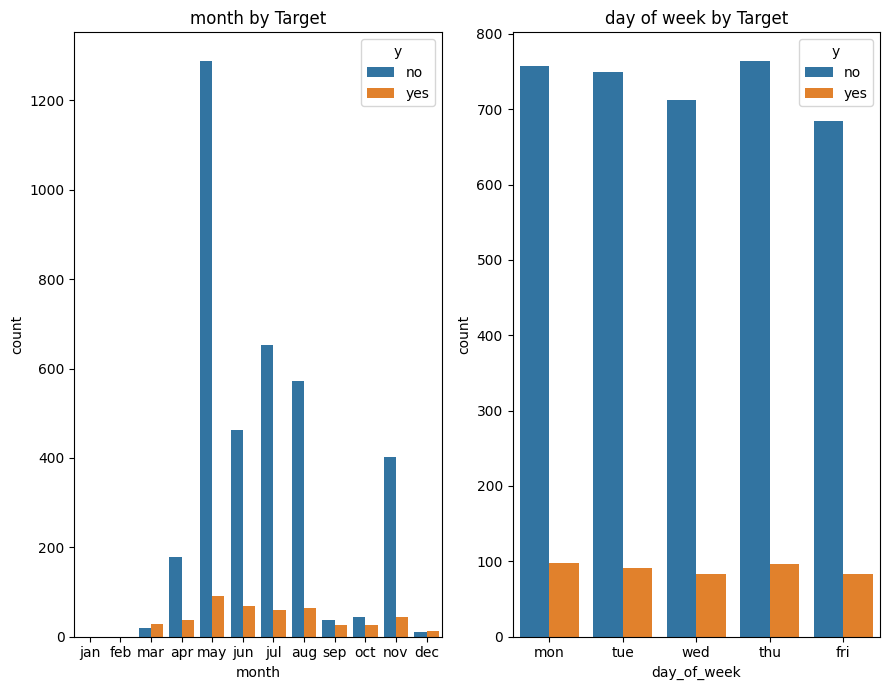

In [26]:
plt.figure(figsize=(9, 7))
plt.subplot(1, 2, 1)

sns.countplot(x='month', hue='y', data=df)
plt.title('month by Target')

plt.subplot(1, 2, 2)
sns.countplot(x='day_of_week', hue='y', data=df)
plt.title('day of week by Target')

plt.tight_layout()
plt.show()

In [27]:
# groupby month, day of week with target variable

df_agg = df.groupby(['month', 'day_of_week', 'y']).size().reset_index(name='count')

In [28]:
df_agg.head()

,month,day_of_week,y,count
0,jan,mon,no,0
1,jan,mon,yes,0
2,jan,tue,no,0
3,jan,tue,yes,0
4,jan,wed,no,0


In [29]:
fig = go.Figure()

for day in df_agg['day_of_week'].unique():
    data = df_agg[df_agg['day_of_week'] == day]
    fig.add_trace(go.Bar(x=data['month'], y=data['count'], name=day))

fig.update_layout(
    barmode='group',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    title='Grouped Bar Chart of Month and Day of Week vs. Target (y)'
)

fig.show()

Duration column -

In [30]:
print(df.groupby('y')['duration'].describe())

      count       mean         std   min    25%    50%    75%     max
y                                                                    
no   3668.0  219.40976  198.256347   0.0   96.0  165.0  274.0  3253.0
yes   451.0  560.78714  411.537717  63.0  255.5  458.0  761.0  3643.0


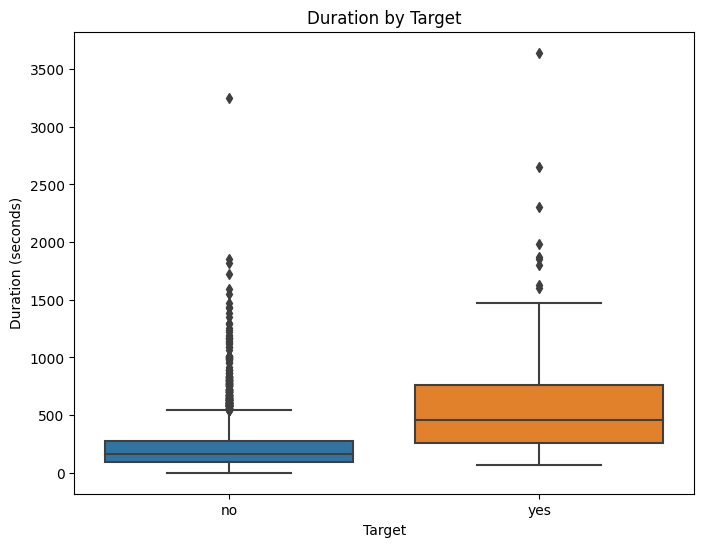

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Duration by Target')
plt.xlabel('Target')
plt.ylabel('Duration (seconds)')
plt.show()

In [32]:
from scipy import stats

# t-test to check if there's a significant difference between 'yes' and 'no'
duration_yes = df[df['y'] == 'yes']['duration']
duration_no = df[df['y'] == 'no']['duration']
t_stat, p_value = stats.ttest_ind(duration_yes, duration_no)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check the significance level (usually 0.05)
alpha = 0.05
print("There is a significant difference between 'yes' and ' no' groups.") if p_value < alpha else print("There is no significant difference between 'yes' and 'no' groups.")

T-test statistic: 29.57185726364515
P-value: 1.902622447564083e-174
There is a significant difference between 'yes' and ' no' groups.


In [33]:
import pandas as pd
from scipy.stats import chi2_contingency

# Automatically create duration bins and labels based on quantiles
num_bins = 15 # You can adjust the number of bins as needed
df['duration_category'] = pd.qcut(df['duration'], q=num_bins, labels=False)

# Perform the chi-squared test
contingency_table = pd.crosstab(df['y'], df['duration_category'])
chi2, p, _, _= chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

# Check the significance level (usually 0.05)
alpha = 0.05
print("There is a significant relationship between 'y' and 'duration_category'.") if p < alpha else print("There is no significant relationship between 'y' and 'duration_category'.")

Chi-squared statistic: 756.2861115320213
P-value: 2.4552136367227164e-152
There is a significant relationship between 'y' and 'duration_category'.


In [34]:
# cancel the duration column after benchmarking !!!

Campaign column

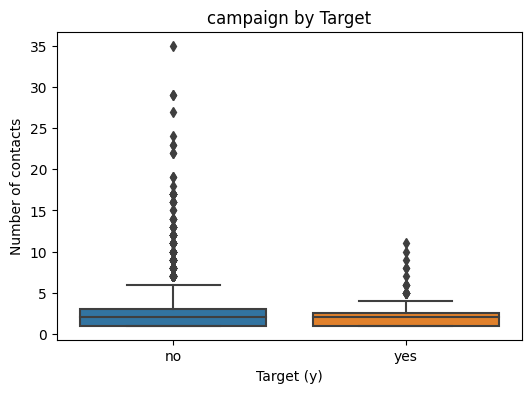

In [35]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='y', y='campaign', data=df)
plt.title(f'campaign by Target')
plt.xlabel('Target (y)')
plt.ylabel('Number of contacts')
plt.show()

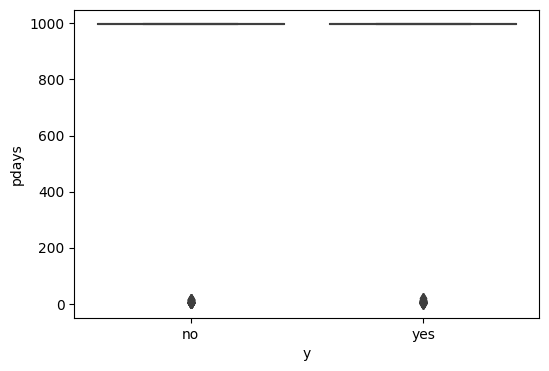

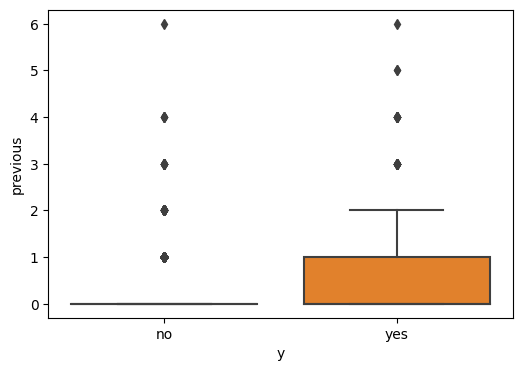

In [36]:
num_feat_01 = ['pdays', 'previous']

for f in num_feat_01:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df['y'], y=df[f])
  plt.show()

In [37]:
df.month.value_counts()

may    1378
jul     711
aug     636
jun     530
nov     446
apr     215
oct      69
sep      64
mar      48
dec      22
jan       0
feb       0
Name: month, dtype: int64

In [38]:
df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0}).astype('int')
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov':11, 'dec': 12 }).astype('int')

In [39]:
df['month_numeric']

0        5
1        5
2        6
3        6
4       11
        ..
4114     7
4115     7
4116     5
4117     8
4118    11
Name: month_numeric, Length: 4119, dtype: int64

## Pairplot - financial coeff

In [40]:
# sns.set(rc={"figure.figsize":(32, 12)})

# data_coeffs = ['month_numeric', 'emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

# sns.pairplot(df[data_coeffs], hue="y")

# plt.show()

## Relacje pomiędzy zmiennymi w Data Frame

### Wartości numeryczne między sobą

In [41]:
numerical_features=[col for col in df.select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
print(numerical_features)
print(len(numerical_features))
print(type(numerical_features))

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'duration_category', 'month_numeric']
12
<class 'list'>


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'duration'),
  Text(2.5, 0, 'campaign'),
  Text(3.5, 0, 'pdays'),
  Text(4.5, 0, 'previous'),
  Text(5.5, 0, 'emp.var.rate'),
  Text(6.5, 0, 'cons.price.idx'),
  Text(7.5, 0, 'cons.conf.idx'),
  Text(8.5, 0, 'euribor3m'),
  Text(9.5, 0, 'nr.employed'),
  Text(10.5, 0, 'duration_category'),
  Text(11.5, 0, 'month_numeric')])

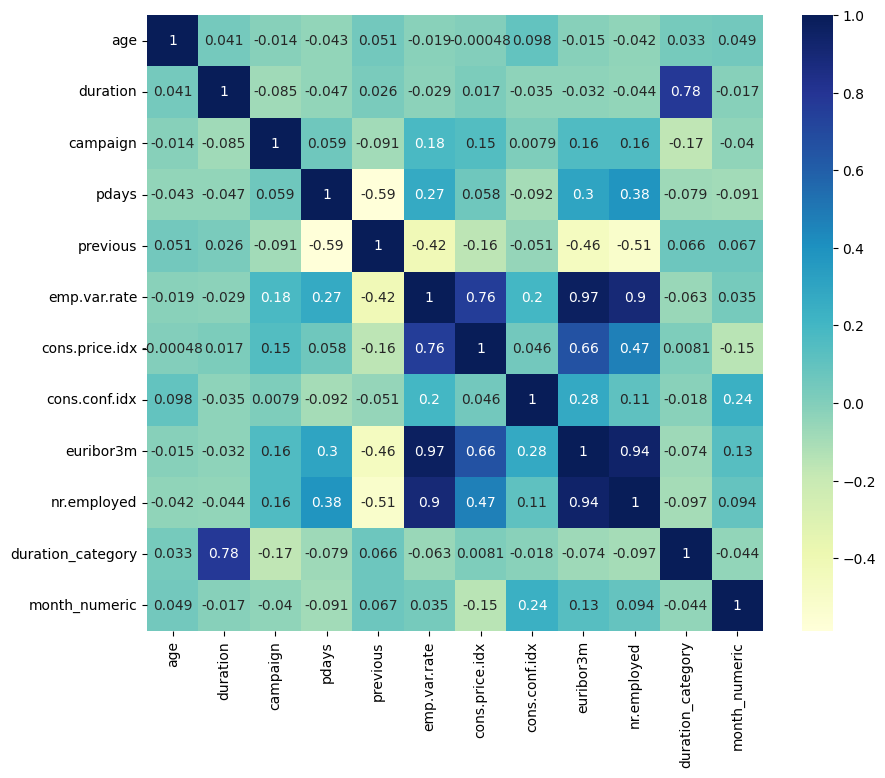

In [42]:
correlations=df[numerical_features].corr()
plt.figure(figsize=(10,8))

sns.heatmap(data=correlations,square=True,annot = True, cmap="YlGnBu")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [43]:
# Calculate and display PPS scores for all pairs of numeric variables
for var1 in numerical_features:
    for var2 in numerical_features:
        if var1 != var2:
            pps_score = pps.score(df, var1, var2)['ppscore']
            print(f'PPS Score between {var1} and {var2}: {pps_score:.2f}')

PPS Score between age and duration: 0.00
PPS Score between age and campaign: 0.00
PPS Score between age and pdays: 0.00
PPS Score between age and previous: 0.00
PPS Score between age and emp.var.rate: 0.00
PPS Score between age and cons.price.idx: 0.00
PPS Score between age and cons.conf.idx: 0.00
PPS Score between age and euribor3m: 0.00
PPS Score between age and nr.employed: 0.00
PPS Score between age and duration_category: 0.00
PPS Score between age and month_numeric: 0.00
PPS Score between duration and age: 0.00
PPS Score between duration and campaign: 0.00
PPS Score between duration and pdays: 0.00
PPS Score between duration and previous: 0.00
PPS Score between duration and emp.var.rate: 0.00
PPS Score between duration and cons.price.idx: 0.00
PPS Score between duration and cons.conf.idx: 0.00
PPS Score between duration and euribor3m: 0.00
PPS Score between duration and nr.employed: 0.00
PPS Score between duration and duration_category: 1.00
PPS Score between duration and month_nu

### Wartości numeryczne vs target column

In [44]:
df_copy = df.copy()

In [45]:
df_copy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11


In [46]:
y_numeric = df_copy.pop('y_numeric')

In [47]:
X = df_copy
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,month_numeric
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,5
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,5
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,6
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,6
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,11


In [48]:
X[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4119 non-null   int64  
 1   duration           4119 non-null   int64  
 2   campaign           4119 non-null   int64  
 3   pdays              4119 non-null   int64  
 4   previous           4119 non-null   int64  
 5   emp.var.rate       4119 non-null   float64
 6   cons.price.idx     4119 non-null   float64
 7   cons.conf.idx      4119 non-null   float64
 8   euribor3m          4119 non-null   float64
 9   nr.employed        4119 non-null   float64
 10  duration_category  4119 non-null   int64  
 11  month_numeric      4119 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 386.3 KB


In [49]:
y_numeric.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4119 entries, 0 to 4118
Series name: y_numeric
Non-Null Count  Dtype
--------------  -----
4119 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB


In [50]:
# sprawdzenie korelacji między zmiennymi numerycznymi a targetem ('y_numeric')
for f in numerical_features:
  print(f'\nFeature: {f}')
  print(stats.pointbiserialr(X[f], y_numeric))


Feature: age
SignificanceResult(statistic=0.060374082506977636, pvalue=0.00010569353749626029)

Feature: duration
SignificanceResult(statistic=0.4185653682346244, pvalue=1.9026224475643572e-174)

Feature: campaign
SignificanceResult(statistic=-0.07609088294850745, pvalue=1.0131007149573394e-06)

Feature: pdays
SignificanceResult(statistic=-0.3320115339486591, pvalue=1.442855865352259e-106)

Feature: previous
SignificanceResult(statistic=0.25569662959028744, pvalue=1.725690840999725e-62)

Feature: emp.var.rate
SignificanceResult(statistic=-0.2832156765328247, pvalue=7.822982265332988e-77)

Feature: cons.price.idx
SignificanceResult(statistic=-0.09832603241628189, pvalue=2.5500558703296847e-10)

Feature: cons.conf.idx
SignificanceResult(statistic=0.05439301829399087, pvalue=0.0004786306153979258)

Feature: euribor3m
SignificanceResult(statistic=-0.2985649713595469, pvalue=1.4082264365897354e-85)

Feature: nr.employed
SignificanceResult(statistic=-0.3492412340486664, pvalue=1.84212732949

Zgodnie z informacją w danych - korelacja międzu duration - oraz przetworzoną jej formą duration_category mają dużą korleacją pozytywną ze y - z wuagi na specyfikę zmiennje, będzie później usunięta

## Wizualizacja danych kategorycznych

In [51]:
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != 'y']
print(categorical_features)
print(len(categorical_features))
print(type(categorical_features))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
10
<class 'list'>


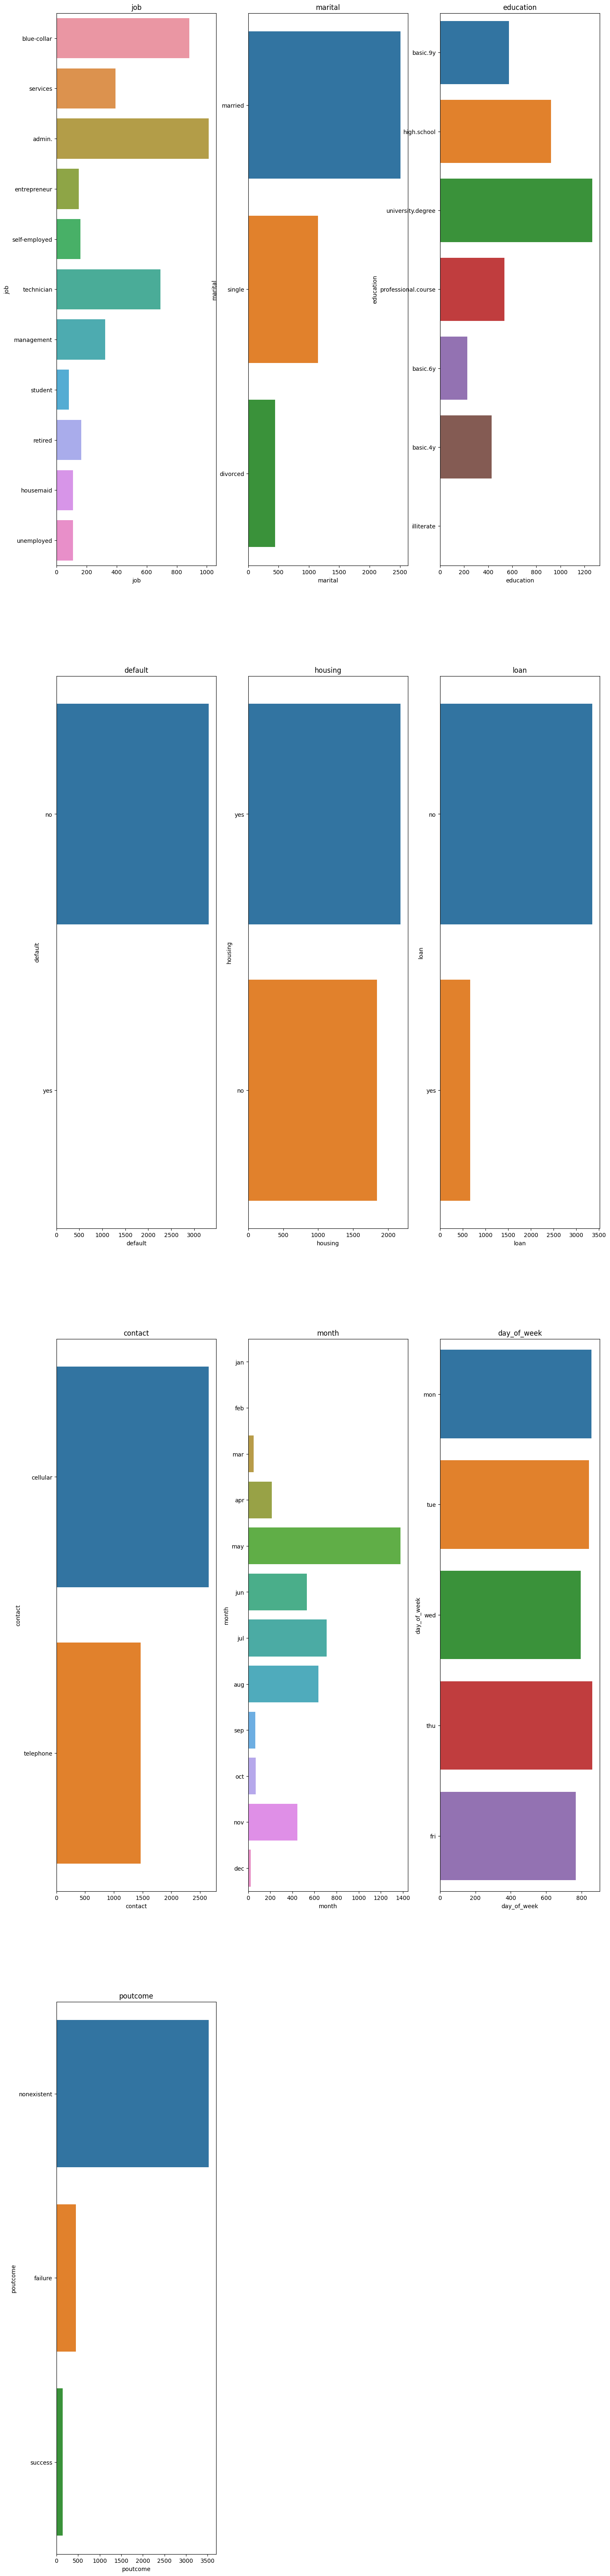

In [52]:
plt.figure(figsize=(17, 80), facecolor='white')
plotnumber = 1
for categorical_feature in categorical_features:
    ax = plt.subplot(4, 3, plotnumber)
    sns.countplot(y=categorical_feature, data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber += 1
plt.show()

### Sprawdzenie relacji między zmiennymi kategorycznymi oraz targetem za pomconą Information gain w decision tree

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

target_col = 'y'
target = df[target_col]

df_cat_feat = df[categorical_features]

df_encoded = pd.get_dummies(df_cat_feat, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy')  # Information Gain criterion
clf.fit(X_train, y_train)

# Get feature importances (information gain)
feature_importance = clf.feature_importances_

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(df_encoded.columns, feature_importance))

# Sort the feature-importance dictionary by information gain
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print the sorted feature-importance pairs
for feature, info_gain in sorted_feature_importance.items():
    print(f"Feature: {feature}, Information Gain: {info_gain:.4f}")

Feature: poutcome_success, Information Gain: 0.1044
Feature: housing_yes, Information Gain: 0.0731
Feature: day_of_week_wed, Information Gain: 0.0524
Feature: job_technician, Information Gain: 0.0484
Feature: loan_yes, Information Gain: 0.0475
Feature: day_of_week_thu, Information Gain: 0.0443
Feature: day_of_week_tue, Information Gain: 0.0408
Feature: day_of_week_fri, Information Gain: 0.0384
Feature: marital_married, Information Gain: 0.0358
Feature: education_university.degree, Information Gain: 0.0325
Feature: marital_single, Information Gain: 0.0311
Feature: month_jun, Information Gain: 0.0305
Feature: month_nov, Information Gain: 0.0286
Feature: job_management, Information Gain: 0.0283
Feature: month_may, Information Gain: 0.0276
Feature: contact_telephone, Information Gain: 0.0276
Feature: month_jul, Information Gain: 0.0264
Feature: education_high.school, Information Gain: 0.0233
Feature: poutcome_nonexistent, Information Gain: 0.0232
Feature: month_aug, Information Gain: 0.023

In summary, the results suggest that 'poutcome_success',  certain day-of-the-week, housing-related, loan features are the most influential in predicting the target variable 'y'.It is possible to use this information to prioritize feature selection or further investigate the relationships between these features and the target variable in your dataset.

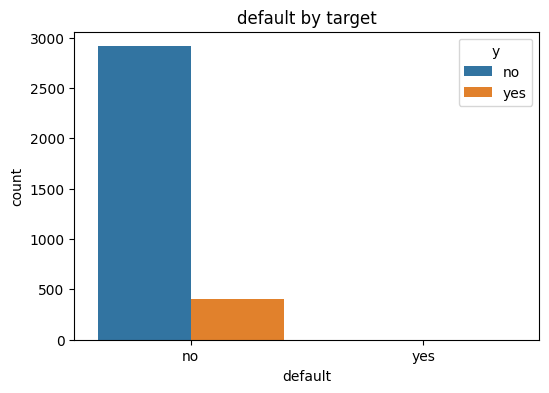

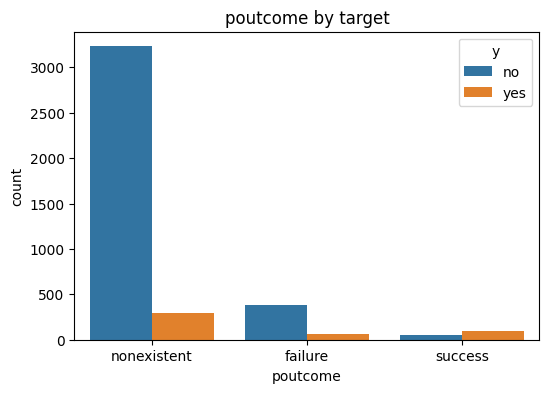

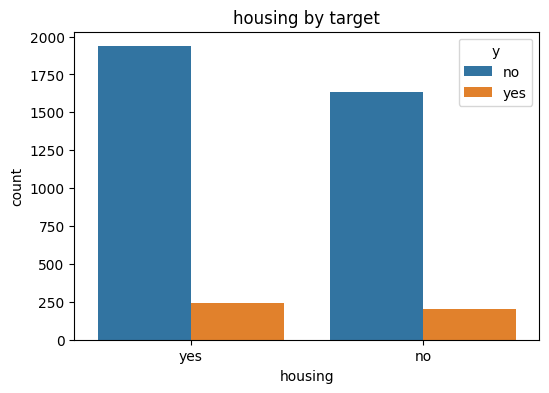

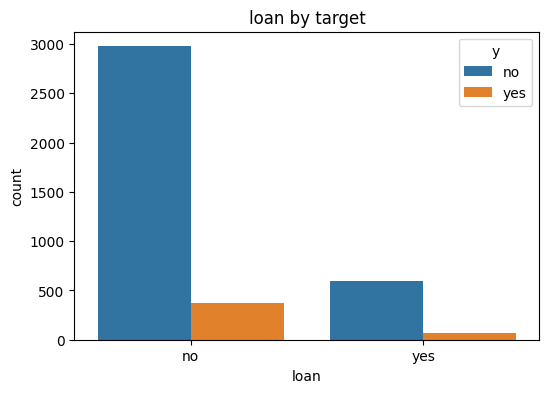

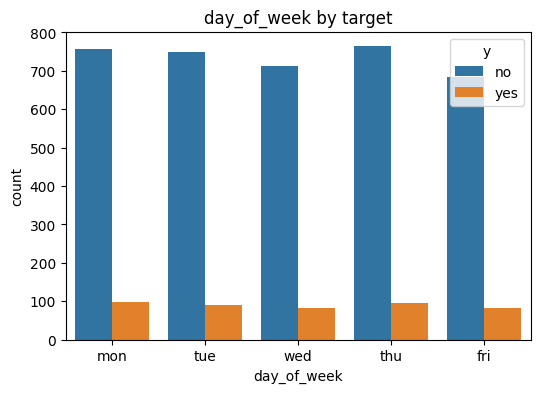

In [54]:
cat_features_vis = ['default', 'poutcome', 'housing', 'loan', 'day_of_week']

for f in cat_features_vis:
  plt.figure(figsize=(6, 4), facecolor='white')
  sns.countplot(x=f, hue='y', data=df)
  print()
  plt.title(f'{f} by target')

## analiza współczynników społecznych / ekonomicznych emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed' - dodanie zmiennej year

zmiana wartości euribor na koszyki

In [55]:
# Calculate the minimum and maximum values from the DataFrame
min_value_eur = df['euribor3m'].min()
max_value_eur = df['euribor3m'].max()

# Define the bin width
bin_width = 0.5

# # Create a list of bin edges (start, stop, and step)
# bins = [x for x in range(int(min_value_eur), int(max_value_eur) + 1, int(bin_width))]

# # Create a new column with the bin labels
# df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

# Create a list of bin edges (start, stop, and step) using numpy.arange
bins = np.arange(int(min_value_eur), int(max_value_eur) + bin_width, bin_width)

bins = np.linspace(int(min_value_eur), max_value_eur, num_bins + 1)

# Create a new column with the bin labels
df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

In [56]:
print(df['euribor3m_binned'])
print(df['euribor3m'])

0       1.009000
1       4.708667
2       4.708667
3       4.708667
4       4.036000
          ...   
4114    4.708667
4115    4.708667
4116    1.345333
4117    4.708667
4118    4.036000
Name: euribor3m_binned, Length: 4119, dtype: category
Categories (15, float64): [0.000000 < 0.336333 < 0.672667 < 1.009000 ... 3.699667 < 4.036000 < 4.372333 <
                           4.708667]
0       1.313
1       4.855
2       4.962
3       4.959
4       4.191
        ...  
4114    4.958
4115    4.959
4116    1.354
4117    4.966
4118    4.120
Name: euribor3m, Length: 4119, dtype: float64


In [57]:
len(df['euribor3m_binned'].unique())

10

In [58]:
numerical_features.append('euribor3m_binned')

In [59]:
for column in df[numerical_features]:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}: {', '.join(map(str, unique_values))}")

Unique values in column age: 30, 39, 25, 38, 47, 32, 41, 31, 35, 36, 29, 27, 44, 46, 45, 50, 55, 40, 28, 34, 33, 51, 48, 20, 76, 56, 24, 58, 60, 37, 52, 42, 49, 54, 59, 57, 43, 53, 75, 82, 71, 21, 22, 23, 26, 81, 61, 67, 73, 18, 64, 74, 77, 86, 85, 63, 88, 78, 72, 68, 80, 66, 19, 62, 65, 69, 70
Unique values in column duration: 487, 346, 227, 17, 58, 128, 290, 44, 68, 170, 301, 148, 97, 211, 553, 698, 191, 59, 38, 849, 326, 222, 626, 119, 388, 479, 446, 127, 109, 113, 393, 151, 256, 42, 525, 57, 499, 84, 137, 31, 430, 126, 340, 412, 132, 79, 341, 157, 252, 263, 215, 89, 143, 40, 10, 481, 233, 204, 403, 180, 16, 447, 81, 361, 1091, 395, 432, 596, 77, 768, 96, 357, 459, 11, 264, 93, 374, 158, 95, 835, 505, 300, 390, 274, 135, 257, 268, 477, 91, 76, 103, 436, 483, 250, 259, 389, 7, 123, 92, 297, 406, 104, 854, 147, 203, 149, 144, 394, 523, 73, 197, 108, 80, 114, 122, 1161, 181, 239, 360, 314, 984, 663, 141, 706, 797, 311, 63, 111, 49, 171, 242, 279, 246, 309, 168, 153, 152, 90, 117, 640, 

In [60]:
columns_coeff = ['emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'euribor3m_binned']

value_mappings = {}

for column in df[columns_coeff]:
    unique_values = df[column].unique()
    value_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
    value_mappings[column] = value_mapping

for column in df[columns_coeff]:
    new_column_name = f"{column}_updated"
    df[new_column_name] = df[column].map(value_mappings[column])

print(df)

      age          job  marital          education default housing loan  \
0      30  blue-collar  married           basic.9y      no     yes   no   
1      39     services   single        high.school      no      no   no   
2      25     services  married        high.school      no     yes   no   
3      38     services  married           basic.9y      no     NaN  NaN   
4      47       admin.  married  university.degree      no     yes   no   
...   ...          ...      ...                ...     ...     ...  ...   
4114   30       admin.  married           basic.6y      no     yes  yes   
4115   39       admin.  married        high.school      no     yes   no   
4116   27      student   single        high.school      no      no   no   
4117   58       admin.  married        high.school      no      no   no   
4118   34   management   single        high.school      no     yes   no   

        contact month day_of_week  duration  campaign  pdays  previous  \
0      cellular   may    

In [61]:
# przyporządkowanie roku wierszom na bazie innych danych - 'euribor3m' oraz kolumny 'month' i reszty istniejących kolumn

In [62]:
df['year'] = pd.np.where(df['euribor3m'] > 2.892, '2008', pd.np.where(df['euribor3m'] > 1.05, '2009' , 'others'))

In [63]:
conditions = [
    (df['euribor3m'] > 2.892),
    (df['euribor3m'] > 1.05),
    (df['month_numeric'] == 12),
    ((df['month_numeric'] >= 3) & (df['month_numeric'] <= 6)),
    ((df['month_numeric'] == 7) & (df['nr.employed_updated'] == 7)), # wybieramy lipiec 2009 z wszystkich danych lipcowych
    ((df['month_numeric'] == 8) & (df['nr.employed_updated'] == 7)),
    ((df['month_numeric'] == 9) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 10) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 11) & (df['nr.employed_updated'] == 9))
]
choices = ['2008', '2009', '2009', '2010', '2009', '2009','2009', '2009', '2009']

df['year'] = pd.np.select(conditions, choices, default='2010')

In [64]:
# dtale.show(df)

### visualization column results for variable 'y' (0/1 binary column) with distribution in month (feature) and year (feature) on 1 chart.

In [65]:
df.groupby(['year', 'month_numeric'])['y_numeric'].count().unstack()

month_numeric,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,
2008,NaN,NaN,758.0,431.0,667.0,528.0,NaN,6.0,386.0,1.0
2009,25.0,201.0,597.0,75.0,14.0,75.0,25.0,43.0,36.0,21.0
2010,23.0,14.0,23.0,24.0,30.0,33.0,39.0,20.0,24.0,NaN


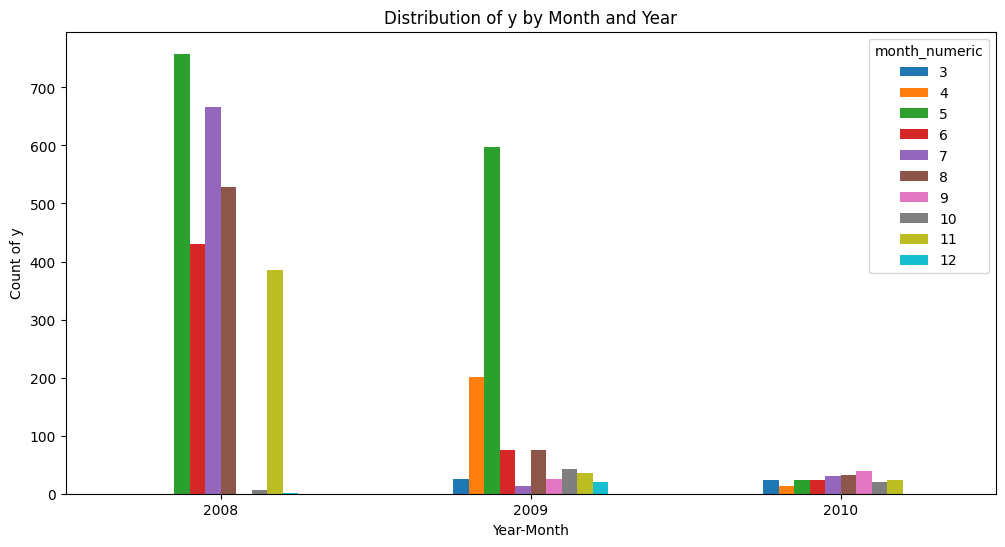

In [66]:
result = df.groupby(['year', 'month_numeric'])['y'].count().unstack(fill_value=0)

# Plot the results as a bar chart
result.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='month_numeric')
plt.xticks(rotation=0)
plt.show()


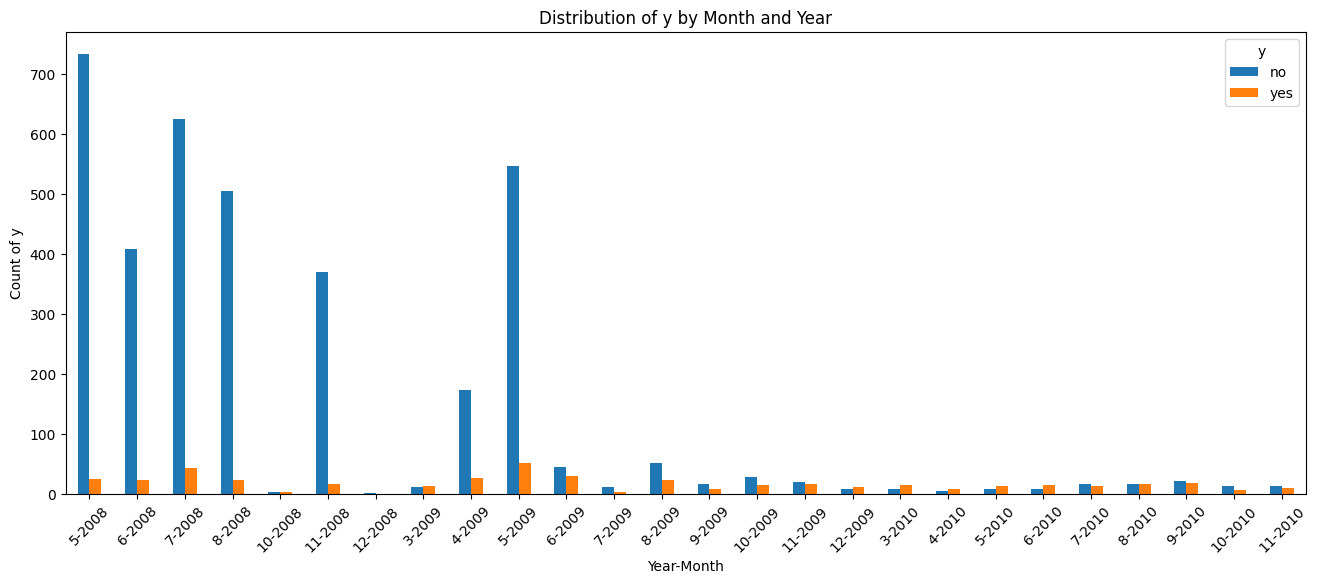

In [67]:
result = df.groupby(['year', 'month_numeric', 'y'])['y'].count().unstack(fill_value=0)

# Create a list of labels with year below each group of months
x_labels = [f"{month}-{year}" for (year, month) in result.index]

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(16, 6))  # Extend the width of the chart
result.plot(kind='bar', ax=ax)

# Set x-axis labels (grouping months by year)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='y')
plt.xticks(rotation=45)
plt.show()

In [68]:
df['month_object'] = df['month'].astype(str)

In [69]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov


In [70]:
# łączenie kolumn month and w jedną kolumnę
df['month_year'] = df['month_object'] + '_' + df['year'].astype('str')
df['month_year'] = df['month_year'].astype('category')

In [72]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008


# Data Preprocessing

## Wartości null

In [73]:
# Łącznie mamy 1029 wierszy z wartościami null (niektóre w kilku kolumnach)
# Dla 5 kolumn kategorycznych  wartości nulls są zdecydowaną mniejszością (od 1% od 4% wierszy) - dla nich uzupełnię nulle wartością najczęście spotykaną
# dla Kolumny 'default' aż 803 rekordy (19%) stanowią wartości null - z uwagi na to, przekształcę nulls jako odrębną wartość ('unknown'), kolumna ze względu na strukturę

In [74]:
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['marital'].fillna(df['job'].mode()[0], inplace=True)
df['education'].fillna(df['job'].mode()[0], inplace=True)
df['housing'].fillna(df['job'].mode()[0], inplace=True)
df['loan'].fillna(df['job'].mode()[0], inplace=True)

In [75]:
df.isnull().sum()

age                           0
job                           0
marital                       0
education                     0
default                     803
housing                       0
loan                          0
contact                       0
month                         0
day_of_week                   0
duration                      0
campaign                      0
pdays                         0
previous                      0
poutcome                      0
emp.var.rate                  0
cons.price.idx                0
cons.conf.idx                 0
euribor3m                     0
nr.employed                   0
y                             0
duration_category             0
y_numeric                     0
month_numeric                 0
euribor3m_binned              0
emp.var.rate_updated          0
cons.price.idx_updated        0
cons.conf.idx_updated         0
euribor3m_updated             0
nr.employed_updated           0
euribor3m_binned_updated      0
year    

Strukura kolumny 'default', nie pozwala jej wziąć do modelowania

In [76]:
df['default'].value_counts()

no     3315
yes       1
Name: default, dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       4119 non-null   int64   
 1   job                       4119 non-null   object  
 2   marital                   4119 non-null   object  
 3   education                 4119 non-null   object  
 4   default                   3316 non-null   object  
 5   housing                   4119 non-null   object  
 6   loan                      4119 non-null   object  
 7   contact                   4119 non-null   object  
 8   month                     4119 non-null   category
 9   day_of_week               4119 non-null   category
 10  duration                  4119 non-null   int64   
 11  campaign                  4119 non-null   int64   
 12  pdays                     4119 non-null   int64   
 13  previous                  4119 non-null   int64 

## Podział danych na zbiór treningowy i testowy

In [78]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,admin.,admin.,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008


In [79]:
# # kopia zestawu danych
# data = df.copy()
# data.head()

* bez kolumny 'default',
* w liście zapisane zmienne zmienne do modelowania

### Zestaw danych nr 1

In [80]:
model_columns = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
      'y_numeric']

print(len(model_columns))
print(model_columns)

19
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y_numeric']


In [81]:
data = df[model_columns]
y = data.pop('y_numeric')
y

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [82]:
X = data
X.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,admin.,admin.,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4119 non-null   int64   
 1   job             4119 non-null   object  
 2   marital         4119 non-null   object  
 3   education       4119 non-null   object  
 4   housing         4119 non-null   object  
 5   loan            4119 non-null   object  
 6   contact         4119 non-null   object  
 7   month           4119 non-null   category
 8   day_of_week     4119 non-null   category
 9   campaign        4119 non-null   int64   
 10  pdays           4119 non-null   int64   
 11  previous        4119 non-null   int64   
 12  poutcome        4119 non-null   object  
 13  emp.var.rate    4119 non-null   float64 
 14  cons.price.idx  4119 non-null   float64 
 15  cons.conf.idx   4119 non-null   float64 
 16  euribor3m       4119 non-null   float64 
 17  nr.employed   

Przy liście zmiennych pomijamy zmienną 'duration' - specyfika tej zmiennej jest taka, nie będziemy wiedzieli przed wykonaniem konaktu, jak długo potrwa (nie będzie dostępna w danych produkcyjnych)

In [84]:
num_feat = [col for col in df[model_columns].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']

cat_feat = [col for col in df[model_columns].select_dtypes(include=['object']).columns if col != 'y']

ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat)}')
print(num_feat)
print()
print(f'No. of categorical features: {len(cat_feat)}')
print(cat_feat)
print()
print(f'No. of ordinal features: {len(ord_feat)}')
print(ord_feat)

No. of numerical features: 9
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['month', 'day_of_week']


In [85]:
# ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

In [86]:
# ord_feat

In [87]:
seed = 23

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [89]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3295, 18), (3295,), (824, 18), (824,))

In [90]:
y_train.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [91]:
361 / (2934+361)

0.10955993930197269

In [92]:
y_test.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 1

In [93]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat),
        ('ordinal', ordinal_transformer, ord_feat)
    ]
)

rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model', RandomForestClassifier(random_state=seed))])

In [94]:
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7bfcadb96410>)]),
                                                  ['month', 'day_of_week'])])),
                ('rfc_model', RandomForestClassifier(random_state=23))])

In [95]:
feature_importance = rfc_pipeline.steps[-1][1].feature_importances_
all_column_names = X_train.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance: 

 age: 0.026470721797016886
 emp.var.rate: 0.025748390320210243
 cons.price.idx: 0.024999627304387997
 campaign: 0.022470702444370362
 housing: 0.018384364313955917
 month: 0.017760638394431993
 job: 0.01621121844659983
 poutcome: 0.01570832272775445
 euribor3m: 0.015503804087756952
 loan: 0.013337234725216078
 cons.conf.idx: 0.012377842739130798
 day_of_week: 0.010580294044588488
 pdays: 0.009835555202227094
 nr.employed: 0.009386148772101744
 contact: 0.008961679586433114
 marital: 0.007240602926299805
 education: 0.007083976929504337
 previous: 0.0004292342416471478


### Zestaw danych nr 2

z nowo stworzoną zmienną month_year oraz wybranym 1 z 5 wskaźników finansowych  wuagi na ich wysoką kolerację i wspólne zależności (ppsscore) )

In [96]:
model_columns_2 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome',
       'month_year', 'y_numeric']

print(len(model_columns_2))
print(model_columns_2)

14
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'month_year', 'y_numeric']


In [97]:
data_2 = df[model_columns_2]

In [98]:
y_2 = data_2.pop('y_numeric')
y_2

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [99]:
X_2 = data_2
X_2.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,month_year
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,may_2009
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,may_2008
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,jun_2008
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,jun_2008
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,nov_2008


In [100]:
num_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_2)}')
print(num_feat_2)
print()
print(f'No. of categorical features: {len(cat_feat_2)}')
print(cat_feat_2)
print()
print(f'No. of ordinal features: {len(ord_feat_2)}')
print(ord_feat_2)

No. of numerical features: 4
['age', 'campaign', 'pdays', 'previous']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [101]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=seed, stratify=y)

In [102]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((3295, 13), (3295,), (824, 13), (824,))

In [103]:
y_train_2.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [104]:
361 / (2934+361)

0.10955993930197269

In [105]:
y_test_2.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

In [106]:
90 / (734+90)

0.10922330097087378

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 2

In [107]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_2),
        ('ordinal', ordinal_transformer, ord_feat_2)
    ]
)

rfc_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_2', RandomForestClassifier(random_state=seed))])

In [108]:
rfc_pipeline_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7bfcadb96f50>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_2', RandomForestClassifier(random_state=23))])

In [109]:
feature_importance = rfc_pipeline_2.steps[-1][1].feature_importances_
all_column_names = X_train_2.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 2: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 2: 

 age: 0.02543849309174528
 pdays: 0.021529728277326358
 day_of_week: 0.017073542865460256
 housing: 0.016051865657051096
 job: 0.015219849678849571
 month_year: 0.01454672299160436
 loan: 0.013126081653233616
 previous: 0.010621347587241467
 campaign: 0.009593858837670501
 contact: 0.008915612783060516
 marital: 0.006354071124580236
 education: 0.005522337201493888
 poutcome: 0.00039567454743137816


In [110]:
# stop

### Zestaw danych 3

-  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność

In [111]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,admin.,admin.,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008


In [112]:
model_columns_3 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'cons.conf.idx', 'emp.var.rate',
        'y_numeric']

print(len(model_columns_3))
print(model_columns_3)

15
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.conf.idx', 'emp.var.rate', 'y_numeric']


In [113]:
data_3 = df[model_columns_3]

y_3 = data_3.pop('y_numeric')
y_3

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [114]:
X_3 = data_3
X_3.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,cons.conf.idx,emp.var.rate
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,-46.2,-1.8
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,-36.4,1.1
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,-41.8,1.4
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,-41.8,1.4
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-42.0,-0.1


In [115]:
num_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_3)}')
print(num_feat_3)
print()
print(f'No. of categorical features: {len(cat_feat_3)}')
print(cat_feat_3)
print()
print(f'No. of ordinal features: {len(ord_feat_3)}')
print(ord_feat_3)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 1
['day_of_week']


In [116]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=seed, stratify=y)

X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape

((3295, 14), (3295,), (824, 14), (824,))

In [117]:
print(y_train_3.value_counts())

0    2934
1     361
Name: y_numeric, dtype: int64


In [118]:
print(y_test_3.value_counts())

0    734
1     90
Name: y_numeric, dtype: int64


## Feature Importance - RandomForestClassifier() - Zestaw danych nr 3

In [119]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_3),
        ('ordinal', ordinal_transformer, ord_feat_3)
    ]
)

rfc_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_3', RandomForestClassifier(random_state=seed))])

In [120]:
rfc_pipeline_3.fit(X_train_3, y_train_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7bfcada527a0>)]),
                                                  ['day_of_week'])])),
                ('rfc_model_3', RandomForestClassifier(random_state=23))])

In [121]:
feature_importance = rfc_pipeline_3.steps[-1][1].feature_importances_
all_column_names = X_train_3.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 3: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 3: 

 emp.var.rate: 0.02988091879644315
 pdays: 0.02974326995952292
 age: 0.028827775710110255
 job: 0.021597068113747647
 day_of_week: 0.021058552071880704
 cons.conf.idx: 0.020227566009812445
 housing: 0.01900705476136792
 loan: 0.017024071297160118
 previous: 0.014973990453422485
 contact: 0.012539851127491508
 campaign: 0.01196582649272758
 education: 0.009403050274347192
 marital: 0.00882177491031598
 poutcome: 0.00047958900526963764


### Zestaw danych 4

- mix 2 i 3 zestawu - month_year zostawiony +  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność

In [122]:
model_columns_4 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.price.idx', 'emp.var.rate', 'month_year',
        'y_numeric']

print(len(model_columns_4))
print(model_columns_4)


data_4 = df[model_columns_4]


y_4 = data_4.pop('y_numeric')
y_4

X_4 = data_4
X_4.head()


num_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_4)}')
print(num_feat_4)
print()
print(f'No. of categorical features: {len(cat_feat_4)}')
print(cat_feat_4)
print()
print(f'No. of ordinal features: {len(ord_feat_4)}')
print(ord_feat_4)


X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=seed, stratify=y)

X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape

y_train_4.value_counts()

y_test_4.value_counts()


16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'emp.var.rate', 'month_year', 'y_numeric']
No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 4

In [123]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_3),
        ('ordinal', ordinal_transformer, ord_feat_3)
    ]
)

rfc_pipeline_4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_4', RandomForestClassifier(random_state=seed))])

In [124]:
rfc_pipeline_4.fit(X_train_4, y_train_4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7bfcada9e140>)]),
                                                  ['day_of_week'])])),
                ('rfc_model_4', RandomForestClassifier(random_state=23))])

In [125]:
feature_importance = rfc_pipeline_4.steps[-1][1].feature_importances_
all_column_names = X_train_4.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 3: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 3: 

 emp.var.rate: 0.02988091879644315
 pdays: 0.02974326995952292
 age: 0.028827775710110255
 month_year: 0.028592278338211773
 job: 0.021597068113747647
 day_of_week: 0.021058552071880704
 cons.price.idx: 0.020227566009812445
 housing: 0.01900705476136792
 loan: 0.017024071297160118
 previous: 0.014973990453422485
 contact: 0.012539851127491508
 campaign: 0.01196582649272758
 education: 0.009403050274347192
 marital: 0.00882177491031598
 poutcome: 0.00047958900526963764


In [126]:
# stop

#Modelowanie

Realtywnie największy wpływ przy każdym sprawdzeniu mają mają kolumny:

*

In [127]:
# import csv

# file_path = 'data_rfc_pre.csv'

# # Open the CSV file for writing
# with open(file_path, 'w', newline='') as file:
#     writer = csv.writer(file)

#     # Write the data to the CSV file
#     for row in rfc_pre_sorted_importance:
#         writer.writerow(row)

## Baseline Random Forest Classifier - zestaw 1

Komentarz do baseline

In [128]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.67      0.20      0.31        90

    accuracy                           0.90       824
   macro avg       0.79      0.59      0.63       824
weighted avg       0.88      0.90      0.88       824



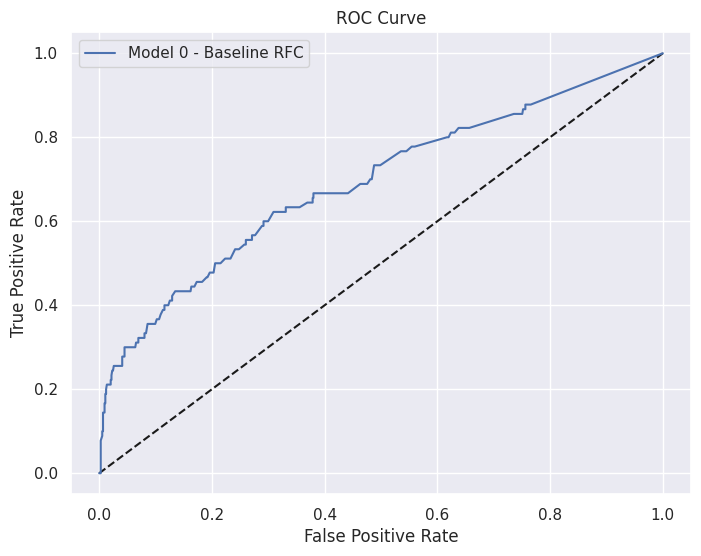

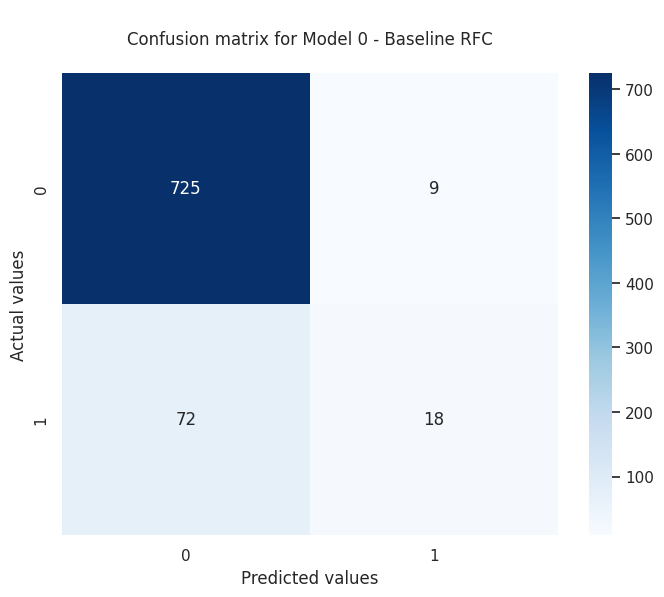

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243


In [129]:
sns.set(rc={"figure.figsize":(8, 6)})
calculation_metrics(rfc_pipeline, 'Model 0 - Baseline RFC')

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.67      0.20      0.31        90

    accuracy                           0.90       824
   macro avg       0.79      0.59      0.63       824
weighted avg       0.88      0.90      0.88       824



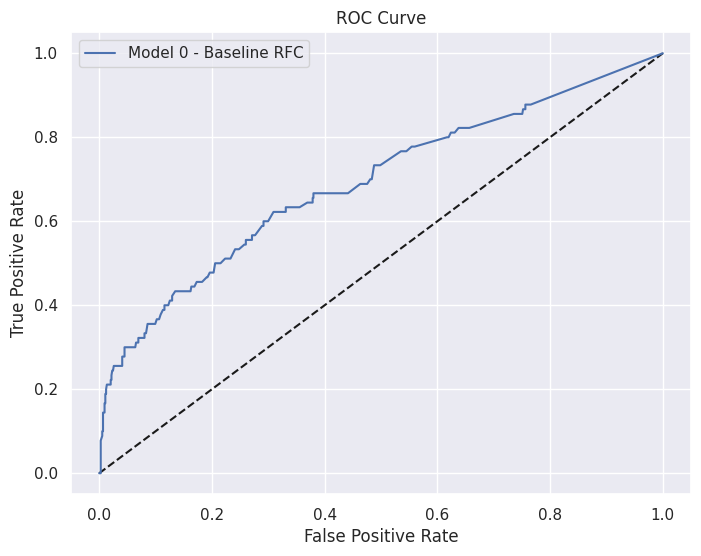

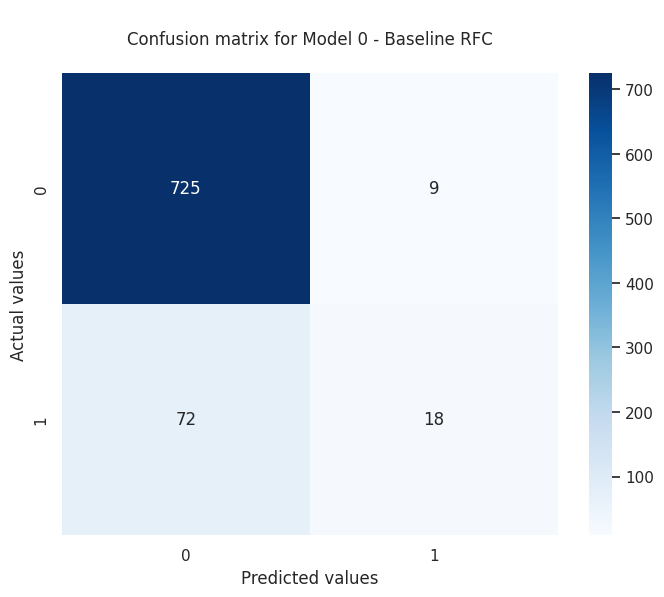

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243


In [130]:
calculation_metrics(rfc_pipeline, 'Model 0 - Baseline RFC')

In [131]:
# # test

# model_names = metrics_dataframe['Model']
# auc_scores = metrics_dataframe['AUC']

# # Create a plot for AUC ROC
# plt.figure(figsize=(10, 6))
# for model_name, auc_score in zip(model_names, auc_scores):
#     # You need to replace the following lines with the actual data and models
#     fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba)  # Replace with actual data
#     plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

In [132]:
# stop

## Model 1 - Logistic Regression zestaw danych 1


* z użyciem zestawu danych nr 1 wraz SMOTE (oversampling danych - przeciwdziałanie niezbalansowaniu - widoczny słabe wyniki prognozy w mniej licznej klasie) - dodanie również StandardScaler() - celem jest sprawdzenie feature importance dla wskaźników finansowych


In [133]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ]
)

lr_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model', LogisticRegression(random_state=seed))])

In [134]:
lr_param_grid = {
    'smote__sampling_strategy': [0.3],
    'smote__k_neighbors': [4],
    'lr_model__C': [ 0.01],
    'lr_model__penalty': ['l2'],
    'lr_model__max_iter': [15],
}

In [135]:
lr_model_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline,
                                       param_grid = lr_param_grid,
                                       scoring='f1_weighted',
                                      #  error_score='raise',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcad8838b0>...
                                                                                 'cons.price.idx',
                                                                                 'cons.conf.idx',
                                                                                 'euribor3m',
                                                                                 'nr.employed'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('lr_model',
                                               LogisticRegression(random_state=23))]),
                    n_jobs=-1,
                    param_grid={'lr_model__C': [0.01],
                                'lr_model__max_iter': [15],
                                'lr_model__penalty': ['l2'],
                                'smote__k_neighbors': [4],
                                'smote__sampling_strategy': [0.3]},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [136]:
print('\nBest hyperparameter:', lr_model_gridsearch.best_params_)


Best hyperparameter: {'lr_model__C': 0.01, 'lr_model__max_iter': 15, 'lr_model__penalty': 'l2', 'smote__k_neighbors': 4, 'smote__sampling_strategy': 0.3}


In [137]:
lr_model = lr_model_gridsearch.best_estimator_

In [138]:
X_test_data = X_test
y_test = y_test

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       734
           1       0.65      0.38      0.48        90

    accuracy                           0.91       824
   macro avg       0.79      0.68      0.71       824
weighted avg       0.90      0.91      0.90       824



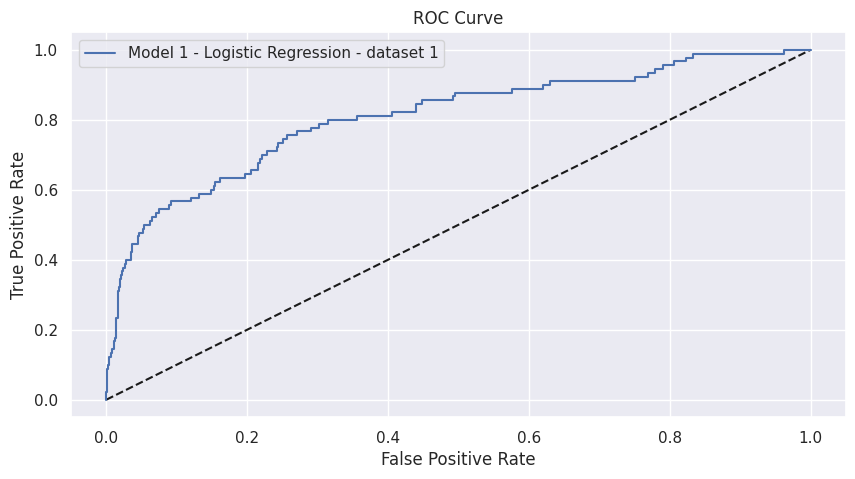

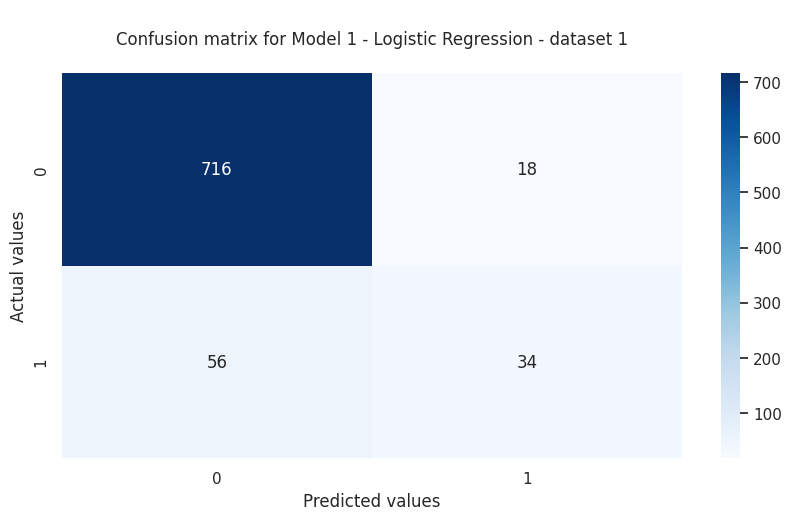

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644


In [139]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model, 'Model 1 - Logistic Regression - dataset 1')

In [140]:
# stop

### Sprawdzenie istotności cech na bazie Regresji Logistycznej - zestaw 1

In [141]:
training_features = list(model_columns)
training_features.remove('y_numeric')

In [142]:
training_features

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [143]:
calculate_and_print_feature_importance(lr_model, training_features)

Feature: housing, Importance: 0.16502965819732027
Feature: poutcome, Importance: 0.15386272746097288
Feature: age, Importance: 0.12167481415921408
Feature: contact, Importance: 0.08920619897907817
Feature: marital, Importance: 0.07270982485137047
Feature: job, Importance: 0.06659289205044891
Feature: pdays, Importance: 0.06495145866603874
Feature: education, Importance: 0.06167247274623049
Feature: cons.price.idx, Importance: 0.060953552873907184
Feature: month, Importance: 0.05905091720395682
Feature: campaign, Importance: 0.04966914667353365
Feature: euribor3m, Importance: 0.04780355838264097
Feature: cons.conf.idx, Importance: 0.040758399074119676
Feature: loan, Importance: 0.025118811312298206
Feature: nr.employed, Importance: 0.02119859573943957
Feature: previous, Importance: 0.021058782611441007
Feature: emp.var.rate, Importance: 0.013573399755350213
Feature: day_of_week, Importance: 0.0033992705156484157


In [144]:
# stop

NameError: ignored

### ???!!!! Porównanie współczynników ???!!!!

In [ ]:
# import csv

# file_path = 'data_LR_1.csv'

# # Open the CSV file for writing
# with open(file_path, 'w', newline='') as file:
#     writer = csv.writer(file)

#     # Write the data to the CSV file
#     for row in lr_trained_sorted_feature_importance:
#         writer.writerow(row)

In [ ]:
# coefficients

In [ ]:
# print(lr_trained_sorted_feature_importance)
# print(type(lr_trained_sorted_feature_importance))
# print()
# print(rfc_pre_sorted_importance)
# print(type(rfc_pre_sorted_importance))

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

# # Sample data for LR feature importance (list of tuples)
# # lr_trained_sorted_feature_importance = [
# #     ('loan', 0.6824466445605666),
# #     ('campaign', 0.5678344582030287),
# #     # ... other LR feature importances ...
# # ]

# # # Sample data for RFC feature importance (list of tuples)
# # rfc_pre_sorted_importance = [
# #     ('poutcome', 0.02691697437537978),
# #     # ... other RFC feature importances ...
# # ]

# # Sort both datasets based on importance values (highest to lowest)
# lr_trained_sorted_feature_importance.sort(key=lambda x: x[1], reverse=True)
# rfc_pre_sorted_importance.sort(key=lambda x: x[1], reverse=True)

# # Extract feature names and importance values
# lr_feature_names, lr_importance_values = zip(*lr_trained_sorted_feature_importance)
# rfc_feature_names, rfc_importance_values = zip(*rfc_pre_sorted_importance)

# print("LR Feature Names:", lr_feature_names)
# print("RFC Feature Names:", rfc_feature_names)

# # Create a MinMaxScaler instance
# scaler = MinMaxScaler()

# # Fit and transform the LR importance values
# lr_importance_scaled = scaler.fit_transform([lr_importance_values]).flatten()

# # Fit and transform the RFC importance values
# rfc_importance_scaled = scaler.fit_transform([rfc_importance_values]).flatten()

# print("LR Importance Scaled:", lr_importance_scaled)
# print("RFC Importance Scaled:", rfc_importance_scaled)

# # Create a custom scaling factor for better visualization
# custom_scaling_factor = 3.0

# # Combine feature names from both datasets
# common_feature_names = list(set(lr_feature_names) & set(rfc_feature_names))

# print("Common Feature Names:", common_feature_names)

# # Plot the scaled and sorted feature importance values
# plt.figure(figsize=(10, 6))
# plt.barh(common_feature_names, custom_scaling_factor * lr_importance_scaled[:len(common_feature_names)], color='b', alpha=0.5, label='LR')
# plt.barh(common_feature_names, custom_scaling_factor * rfc_importance_scaled[:len(common_feature_names)], color='g', alpha=0.5, label='RFC')
# plt.xlabel('Scaled Importance (Custom)')
# plt.title('Feature Importance Comparison')
# plt.legend()
# plt.gca().invert_yaxis()  # Invert the y-axis to show most important features at the top
# plt.show()

In [ ]:
# len(common_feature_names)

In [ ]:
# len(lr_feature_importance_dict)
# len(rfc_feature_importance_dict)
# feature_names
# lr_importance_values
# rfc_importance_values

In [ ]:
# # 2 pomysł z kaggle
# from sklearn.feature_selection import RFE

# rfe = RFE(lr_model)

# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for Logistic Regression model are:')
# print(feature_ranking[feature_ranking.values==1].index.tolist())

In [ ]:
# Model 2 - Logistic Regression zestaw 2

# * z kolumną year oraz wybranym najważniejszym

## Model 2 - Logistic Regression zestaw danych 2

In [155]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ]
)

lr_pipeline_2 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_2', LogisticRegression(random_state=seed))])

In [156]:
lr_param_grid_2 = {
    'smote__sampling_strategy': [0.3,],
    'smote__k_neighbors': [4],
    'lr_model_2__C': [ 0.01,],
    'lr_model_2__penalty': ['l2'],
    'lr_model_2__max_iter': [15,],
}

In [157]:
lr_model_2_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_2,
                                       param_grid = lr_param_grid_2,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_2_gridsearch.fit(X_train_2, y_train_2)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcae013100>...
                                                                                                 StandardScaler())]),
                                                                                ['age',
                                                                                 'campaign',
                                                                                 'pdays',
                                                                                 'previous'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('lr_model_2',
                                               LogisticRegression(random_state=23))]),
                    n_jobs=-1,
                    param_grid={'lr_model_2__C': [0.01],
                                'lr_model_2__max_iter': [15],
                                'lr_model_2__penalty': ['l2'],
                                'smote__k_neighbors': [4],
                                'smote__sampling_strategy': [0.3]},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [158]:
print('\nBest hyperparameter:', lr_model_2_gridsearch.best_params_)


Best hyperparameter: {'lr_model_2__C': 0.01, 'lr_model_2__max_iter': 15, 'lr_model_2__penalty': 'l2', 'smote__k_neighbors': 4, 'smote__sampling_strategy': 0.3}


In [159]:
lr_model_2 = lr_model_2_gridsearch.best_estimator_

In [160]:
X_test_data = X_test_2
y_test_data = y_test_2

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.68      0.23      0.35        90

    accuracy                           0.90       824
   macro avg       0.80      0.61      0.65       824
weighted avg       0.89      0.90      0.88       824



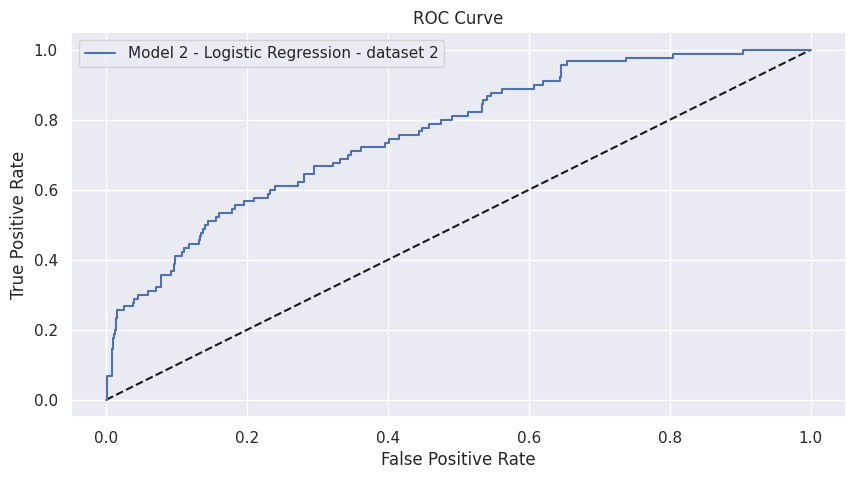

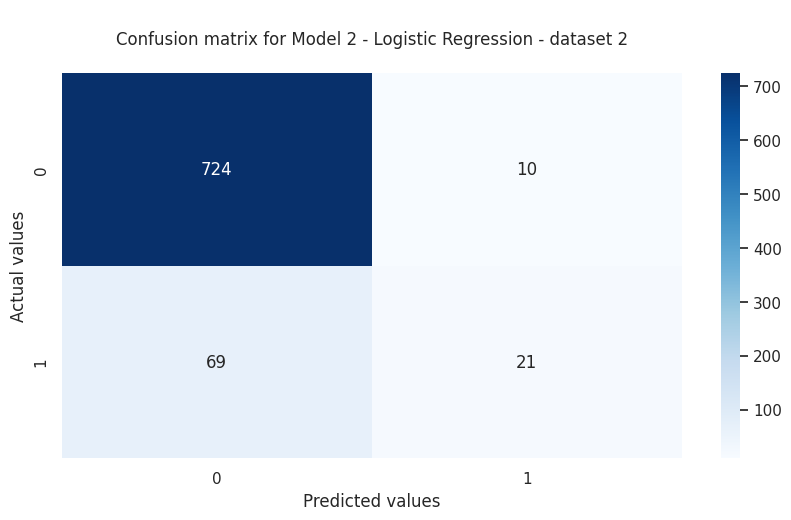

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626


In [161]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_2, 'Model 2 - Logistic Regression - dataset 2')

### Istotność cech Logistic Regression zestaw danych 2

In [165]:
training_features_2 = list(model_columns_2)
training_features_2.remove('y_numeric')
training_features_2

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'month_year']

In [166]:
calculate_and_print_feature_importance(lr_model_2, training_features_2)

Feature: month_year, Importance: 0.15934480448350816
Feature: job, Importance: 0.15717781017268073
Feature: housing, Importance: 0.1274818876016585
Feature: marital, Importance: 0.08690075729341373
Feature: campaign, Importance: 0.07758790641847459
Feature: age, Importance: 0.058781503307003415
Feature: contact, Importance: 0.0576432709237736
Feature: loan, Importance: 0.05723108979954197
Feature: education, Importance: 0.0363515371957743
Feature: day_of_week, Importance: 0.03395089914892858
Feature: previous, Importance: 0.021918162211651188
Feature: poutcome, Importance: 0.014633784697450084
Feature: pdays, Importance: 0.01140151858094679


In [167]:
# stop

## Model 3 - Logistic Regression zestaw danych 3

In [168]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ]
)

lr_pipeline_3 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_3', LogisticRegression(random_state=seed))])

In [169]:
lr_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    # 'lr_model__solver': ['liblinear', 'lbfgs', 'newton-cholesky'], wynik był lepszy w wersji z automatycznym 'lbfgs'
    'lr_model_3__C': [0.01],
    'lr_model_3__penalty': [ 'l2'],
    'lr_model_3__max_iter': [15],
}

In [170]:
lr_model_3_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_3,
                                       param_grid = lr_param_grid_3,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_3_gridsearch.fit(X_train_3, y_train_3)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcab337e20>...
                                                                                 'pdays',
                                                                                 'previous',
                                                                                 'cons.conf.idx',
                                                                                 'emp.var.rate'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('lr_model_3',
                                               LogisticRegression(random_state=23))]),
                    n_jobs=-1,
                    param_grid={'lr_model_3__C': [0.01],
                                'lr_model_3__max_iter': [15],
                                'lr_model_3__penalty': ['l2'],
                                'smote__k_neighbors': [5],
                                'smote__sampling_strategy': [0.8]},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [171]:
print('\nBest hyperparameter:', lr_model_3_gridsearch.best_params_)


Best hyperparameter: {'lr_model_3__C': 0.01, 'lr_model_3__max_iter': 15, 'lr_model_3__penalty': 'l2', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8}


In [172]:
lr_model_3 = lr_model_3_gridsearch.best_estimator_

In [173]:
# X_test_data
# y_test_data

In [174]:
X_test_data = X_test_3
y_test_data = y_test_3

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       734
           1       0.32      0.59      0.41        90

    accuracy                           0.82       824
   macro avg       0.63      0.72      0.65       824
weighted avg       0.88      0.82      0.84       824



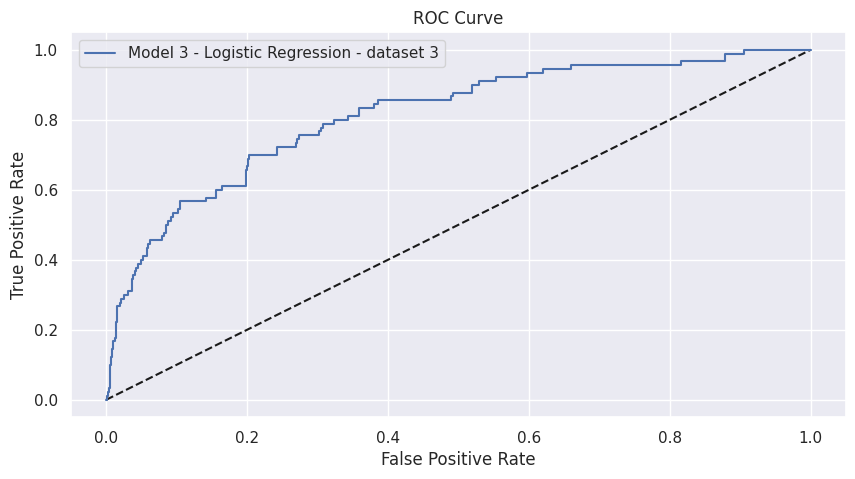

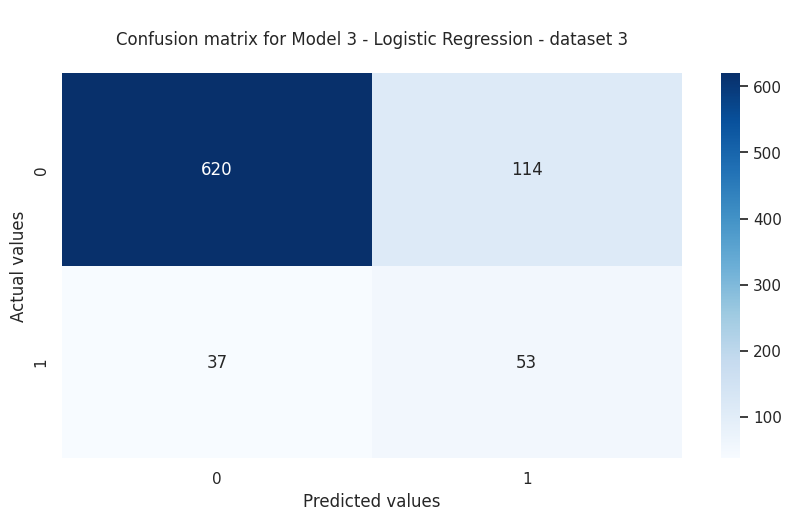

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428


In [175]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_3, 'Model 3 - Logistic Regression - dataset 3')

In [176]:
# stop

### Istotność cech Logistic Regression zestaw 3

In [177]:
training_features_3 = list(model_columns_3)
training_features_3.remove('y_numeric')
training_features_3

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'cons.conf.idx',
 'emp.var.rate']

In [178]:
calculate_and_print_feature_importance(lr_model_3, training_features_3)

Feature: housing, Importance: 0.23143326891350371
Feature: age, Importance: 0.20772885553197795
Feature: cons.conf.idx, Importance: 0.17697733328741388
Feature: pdays, Importance: 0.16211300490190242
Feature: marital, Importance: 0.13863015672190887
Feature: contact, Importance: 0.13422244656022783
Feature: previous, Importance: 0.12251918215548831
Feature: education, Importance: 0.11546939197746225
Feature: loan, Importance: 0.06841541218963895
Feature: day_of_week, Importance: 0.06432635777550552
Feature: campaign, Importance: 0.049010811775349085
Feature: poutcome, Importance: 0.04544615250744619
Feature: job, Importance: 0.012789323056259603
Feature: emp.var.rate, Importance: 0.004387756347572076


## Model 4 - Support Vector Machines() - zestaw 1

In [179]:
data.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,admin.,admin.,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [180]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model', svm.SVC(probability=True))
])



In [181]:
svm_param_grid = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model__C': [0.1],
    'svm_model__kernel': ['rbf'],
    'svm_model__gamma':  [0.01]
}

In [182]:
# dobrane hiperamametry dla svm

# svm_param_grid = {
#     'smote__sampling_strategy': [0.8],
#     'smote__k_neighbors': [5],
#     'svm_model__C': [0.01, 0.1, 1, 10],
#     'svm_model__kernel': ['linear', 'rbf', 'poly'],
#     'svm_model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
# }

In [183]:
svm_search = HalvingGridSearchCV(svm_pipeline,
                                 svm_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcab410250>...
                                                                                 'emp.var.rate',
                                                                                 'cons.price.idx',
                                                                                 'cons.conf.idx',
                                                                                 'euribor3m',
                                                                                 'nr.employed'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('svm_model',
                                               SVC(probability=True))]),
                    n_jobs=-1,
                    param_grid={'smote__k_neighbors': [5],
                                'smote__sampling_strategy': [0.8],
                                'svm_model__C': [0.1],
                                'svm_model__gamma': [0.01],
                                'svm_model__kernel': ['rbf']},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [184]:
print('\nBest hyperparameter:', svm_search.best_params_)


Best hyperparameter: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'svm_model__C': 0.1, 'svm_model__gamma': 0.01, 'svm_model__kernel': 'rbf'}


In [185]:
svm_model = svm_search.best_estimator_

In [186]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       734
           1       0.33      0.64      0.44        90

    accuracy                           0.82       824
   macro avg       0.64      0.74      0.66       824
weighted avg       0.88      0.82      0.84       824



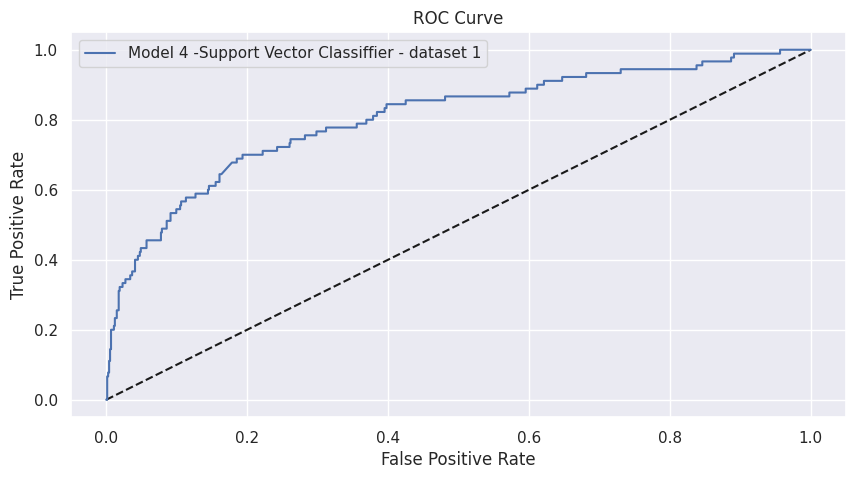

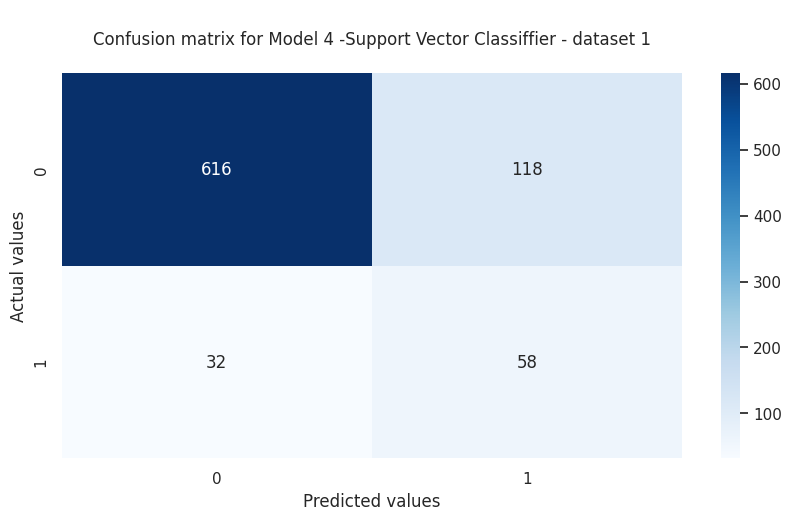

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699


In [187]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model, 'Model 4 -Support Vector Classiffier - dataset 1')

In [188]:
# Użycie funkcji
feature_importance = calculate_and_print_feature_importance_2(svm_model, X_test, y_test)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0456 ± 0.0057  cons.conf.idx
0.0454 ± 0.0070  cons.price.idx
0.0197 ± 0.0095  month
0.0049 ± 0.0046  pdays
0.0036 ± 0.0022  age
0.0027 ± 0.0036  day_of_week
0.0024 ± 0.0053  job
0.0022 ± 0.0018  housing
0.0019 ± 0.0036  poutcome
0.0010 ± 0.0018  marital
0.0005 ± 0.0036  loan
-0.0007 ± 0.0033  campaign
-0.0012 ± 0.0015  previous
-0.0034 ± 0.0138  nr.employed
-0.0034 ± 0.0090  education
-0.0073 ± 0.0051  contact
-0.0167 ± 0.0052  euribor3m
-0.0250 ± 0.0095  emp.var.rate
None


## Model 5 - Support Vector Machines() - zestaw 2

In [189]:
data_2.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,month_year
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,may_2009
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,may_2008
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,jun_2008
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,jun_2008
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,nov_2008


In [190]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_2', svm.SVC(probability=True))
])

In [191]:
svm_param_grid_2 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model_2__C': [0.1],
    'svm_model_2__kernel': ['rbf'],
    'svm_model_2__gamma':  [0.01]
}

In [192]:
svm_search_2 = HalvingGridSearchCV(svm_pipeline_2,
                                 svm_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_2.fit(X_train_2, y_train_2)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcab337940>...
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['age',
                                                                                 'campaign',
                                                                                 'pdays',
                                                                                 'previous'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('svm_model_2',
                                               SVC(probability=True))]),
                    n_jobs=-1,
                    param_grid={'smote__k_neighbors': [5],
                                'smote__sampling_strategy': [0.8],
                                'svm_model_2__C': [0.1],
                                'svm_model_2__gamma': [0.01],
                                'svm_model_2__kernel': ['rbf']},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [193]:
print('\nBest hyperparameter:', svm_search_2.best_params_)


Best hyperparameter: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'svm_model_2__C': 0.1, 'svm_model_2__gamma': 0.01, 'svm_model_2__kernel': 'rbf'}


In [194]:
svm_model_2 = svm_search_2.best_estimator_

In [195]:
X_test_data = X_test_2
y_test_data = y_test_2

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       734
           1       0.60      0.27      0.37        90

    accuracy                           0.90       824
   macro avg       0.76      0.62      0.66       824
weighted avg       0.88      0.90      0.88       824



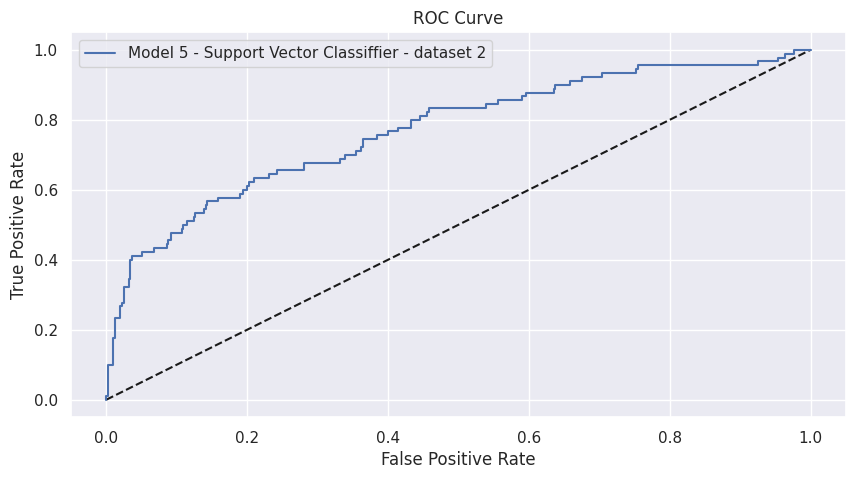

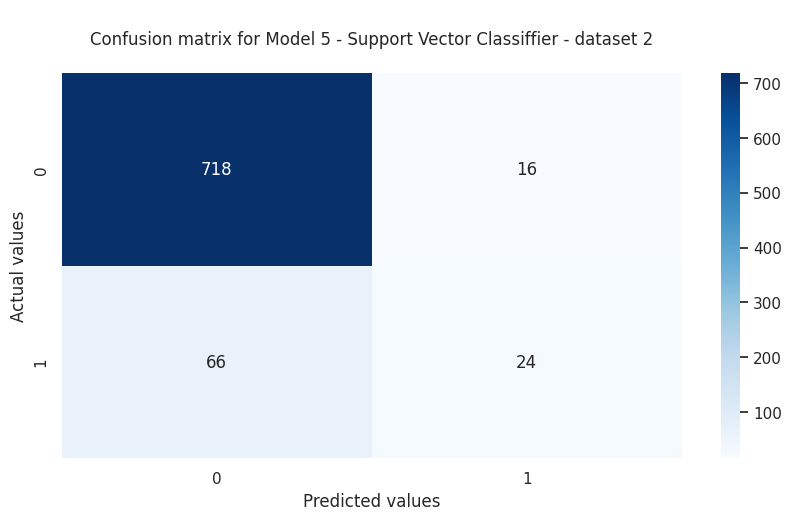

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724


In [196]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_2, 'Model 5 - Support Vector Classiffier - dataset 2')

In [197]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_2, X_test_2, y_test_2)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0415 ± 0.0052  pdays
0.0075 ± 0.0052  month_year
0.0007 ± 0.0025  previous
0.0002 ± 0.0010  job
     0 ± 0.0000  poutcome
     0 ± 0.0000  campaign
     0 ± 0.0000  loan
     0 ± 0.0000  housing
     0 ± 0.0000  marital
     0 ± 0.0000  age
-0.0002 ± 0.0010  day_of_week
-0.0007 ± 0.0012  contact
-0.0007 ± 0.0012  education
None


## Model 6 - Support Vector Machines() - zestaw 3

In [198]:
data_3.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,cons.conf.idx,emp.var.rate
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,-46.2,-1.8
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,-36.4,1.1
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,-41.8,1.4
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,-41.8,1.4
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-42.0,-0.1


In [199]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_3', svm.SVC(probability=True))
])

In [200]:
svm_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model_3__C': [0.1],
    'svm_model_3__kernel': ['rbf'],
    'svm_model_3__gamma':  [0.01]
}

In [201]:
svm_search_3 = HalvingGridSearchCV(svm_pipeline_3,
                                 svm_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_3.fit(X_train_3, y_train_3)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('categorical_transformer',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'poutcome']),
                                                                               ('ordinal_transformer',
                                                                                Pipeline(steps=[('label_encoder',
                                                                                                 <__main__.LabelEncoderTransformer object at 0x7bfcab127010>...
                                                                                ['age',
                                                                                 'campaign',
                                                                                 'pdays',
                                                                                 'previous',
                                                                                 'cons.conf.idx',
                                                                                 'emp.var.rate'])])),
                                              ('smote', SMOTE(random_state=23)),
                                              ('svm_model_3',
                                               SVC(probability=True))]),
                    n_jobs=-1,
                    param_grid={'smote__k_neighbors': [5],
                                'smote__sampling_strategy': [0.8],
                                'svm_model_3__C': [0.1],
                                'svm_model_3__gamma': [0.01],
                                'svm_model_3__kernel': ['rbf']},
                    random_state=23, scoring='f1_weighted', verbose=1)

In [202]:
print('\nBest hyperparameter:', svm_search_3.best_params_)


Best hyperparameter: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'svm_model_3__C': 0.1, 'svm_model_3__gamma': 0.01, 'svm_model_3__kernel': 'rbf'}


In [203]:
svm_model_3 = svm_search_3.best_estimator_

In [204]:
X_test_data = X_test_3
y_test_data = y_test_3

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       734
           1       0.27      0.71      0.39        90

    accuracy                           0.75       824
   macro avg       0.61      0.74      0.62       824
weighted avg       0.88      0.75      0.80       824



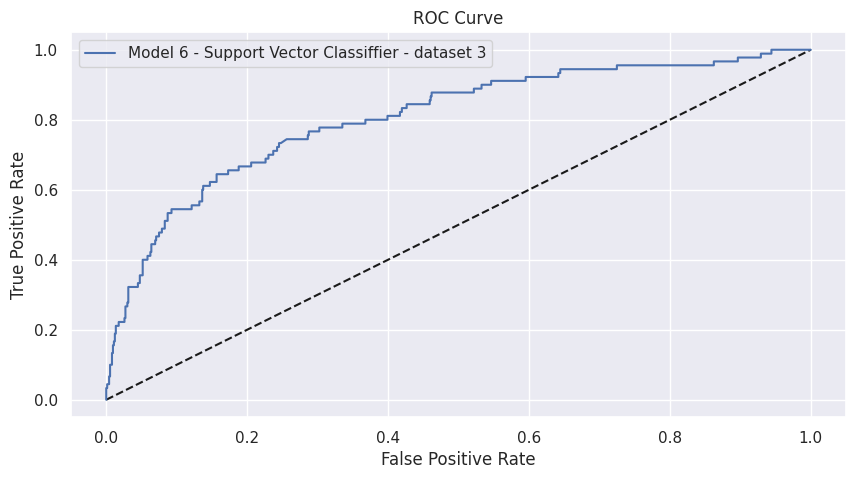

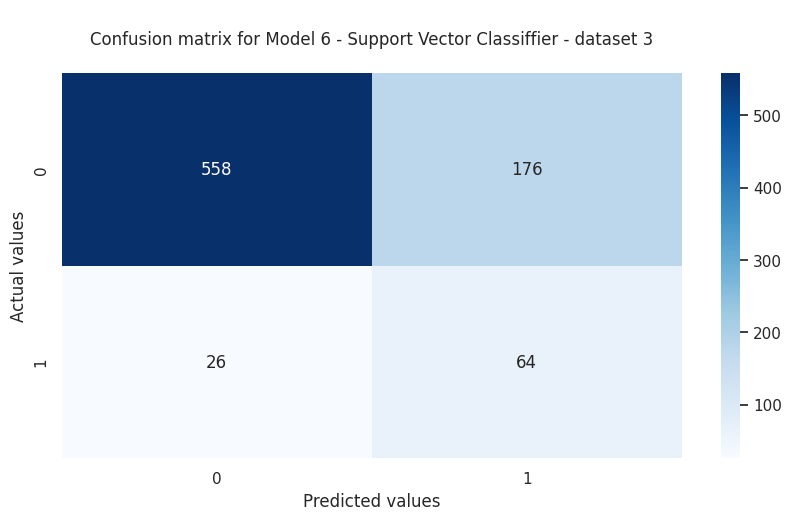

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010


In [205]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_3, 'Model 6 - Support Vector Classiffier - dataset 3')

In [206]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_3, X_test_3, y_test_3)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0825 ± 0.0162  emp.var.rate
0.0150 ± 0.0033  poutcome
0.0100 ± 0.0018  cons.conf.idx
0.0080 ± 0.0012  previous
0.0058 ± 0.0032  pdays
0.0027 ± 0.0028  loan
0.0017 ± 0.0042  day_of_week
0.0012 ± 0.0053  education
-0.0002 ± 0.0018  housing
-0.0007 ± 0.0019  marital
-0.0019 ± 0.0050  job
-0.0039 ± 0.0056  age
-0.0046 ± 0.0086  campaign
-0.0075 ± 0.0052  contact
None


## Model 7 - Support Vector Classifier - zestaw 4

In [207]:
data_4.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,cons.price.idx,emp.var.rate,month_year
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,92.893,-1.8,may_2009
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,93.994,1.1,may_2008
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,94.465,1.4,jun_2008
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,94.465,1.4,jun_2008
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,93.200,-0.1,nov_2008


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best hyperparameter: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'svm_model_4__C': 0.1, 'svm_model_4__gamma': 0.01, 'svm_model_4__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       734
           1       0.36      0.52      0.42        90

    accuracy                           0.84       824
   macro avg       0.65      0.70      0.67       824
weighted avg       0.87      0.84      0.86       824



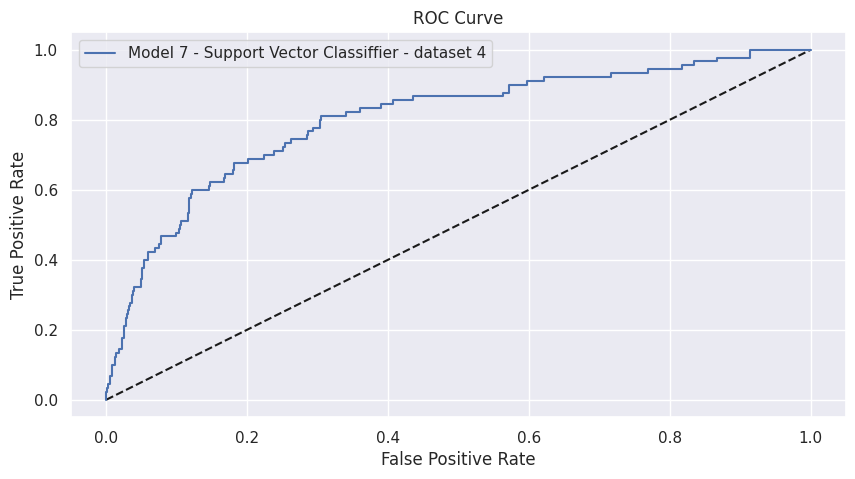

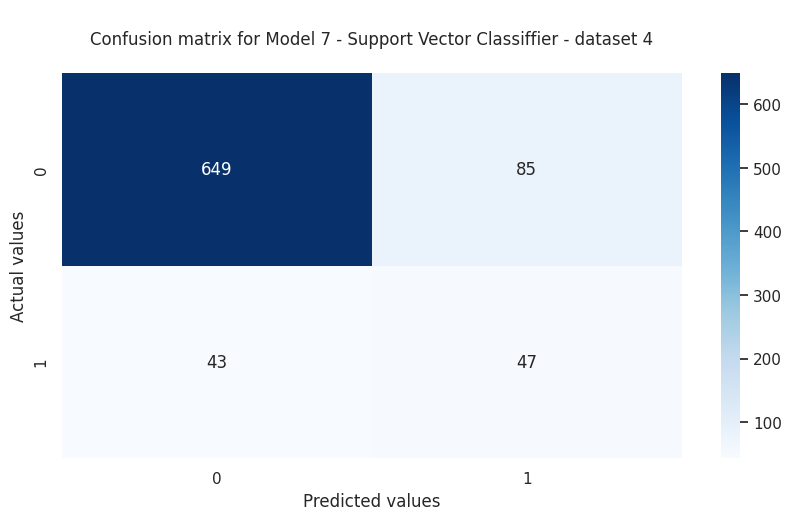

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543


In [208]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_4', svm.SVC(probability=True))
])

svm_param_grid_4 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model_4__C': [0.1],
    'svm_model_4__kernel': ['rbf'],
    'svm_model_4__gamma':  [0.01]
}

svm_search_4 = HalvingGridSearchCV(svm_pipeline_4,
                                 svm_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_4.fit(X_train_4, y_train_4)


print('\nBest hyperparameter:', svm_search_4.best_params_)

svm_model_4 = svm_search_4.best_estimator_

X_test_data = X_test_4
y_test_data = y_test_4

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_4, 'Model 7 - Support Vector Classiffier - dataset 4')

In [209]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_4, X_test_4, y_test_4)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0803 ± 0.0196  emp.var.rate
0.0447 ± 0.0077  month_year
0.0206 ± 0.0053  pdays
0.0002 ± 0.0010  day_of_week
0.0002 ± 0.0018  contact
     0 ± 0.0000  poutcome
     0 ± 0.0000  previous
     0 ± 0.0000  loan
     0 ± 0.0000  housing
     0 ± 0.0000  education
     0 ± 0.0000  marital
     0 ± 0.0000  job
-0.0007 ± 0.0025  campaign
-0.0012 ± 0.0000  age
-0.0032 ± 0.0012  cons.price.idx
None


## Model 8 - XGBoost() - zestaw 1

In [210]:
data.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,admin.,admin.,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 122
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 122
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 9
n_resources: 366
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 3
n_resources: 1098
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 1
n_resources: 3294
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'xgb_model__gamma': 0.01, 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 12, 'xgb_model__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       734
           1       0.50      0.32      0.39        90

    accuracy                    

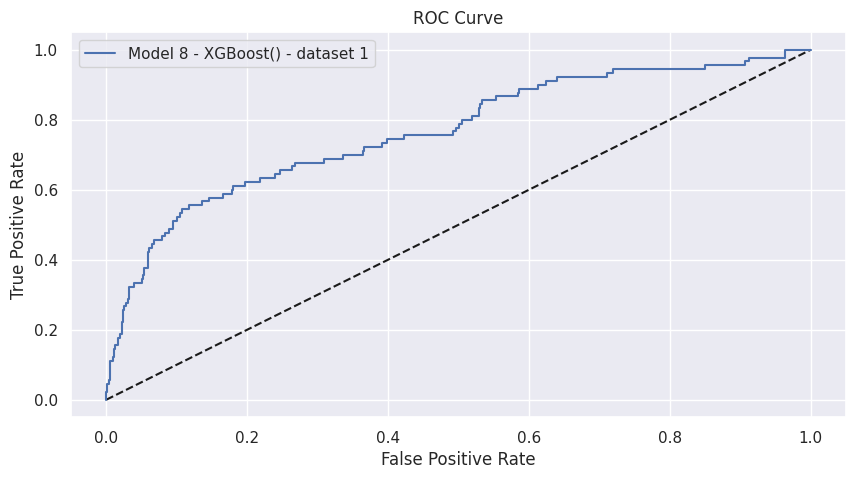

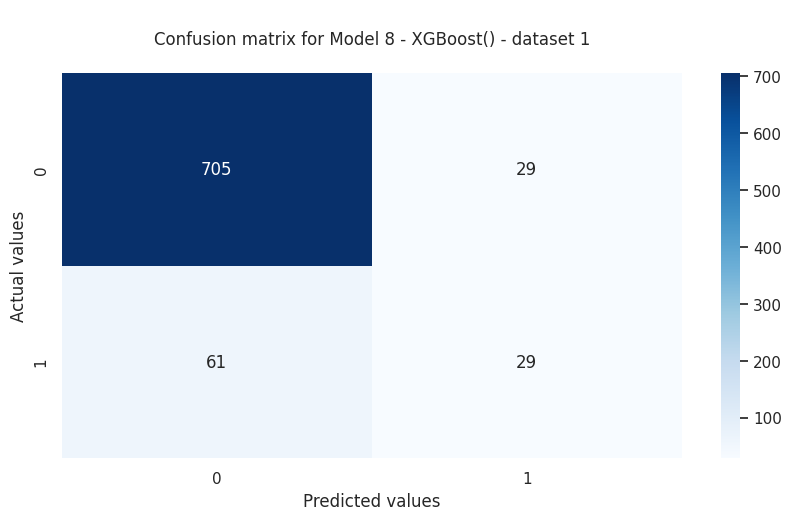

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543
9,Model 8 - XGBoost() - dataset 1,0.391892,0.765637


In [211]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model', XGBClassifier(verbosity=0))
])

xgb_param_grid = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model__n_estimators': [50, 100, 150],  # You can adjust the number of estimators
    'xgb_model__max_depth': [3,6,12],  # You can configure the max depth
    'xgb_model__learning_rate': [0.1, 0.01, 0.001],  # You can configure the learning rate
    'xgb_model__gamma': [0.01]
}

xgb_search = HalvingGridSearchCV(xgb_pipeline,
                                 xgb_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search.fit(X_train, y_train)

print('\nBest hyperparameters:', xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_

X_test_data = X_test
y_test_data = y_test

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model, 'Model 8 - XGBoost() - dataset 1')

In [212]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model, X_test , y_test )
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0371 ± 0.0082  nr.employed
0.0036 ± 0.0022  emp.var.rate
0.0034 ± 0.0080  contact
0.0027 ± 0.0106  marital
0.0024 ± 0.0124  cons.conf.idx
0.0024 ± 0.0015  pdays
0.0017 ± 0.0059  month
0.0010 ± 0.0093  campaign
0.0005 ± 0.0042  euribor3m
     0 ± 0.0000  previous
-0.0002 ± 0.0094  job
-0.0007 ± 0.0050  loan
-0.0012 ± 0.0055  day_of_week
-0.0015 ± 0.0032  age
-0.0019 ± 0.0025  cons.price.idx
-0.0022 ± 0.0024  housing
-0.0044 ± 0.0039  education
-0.0080 ± 0.0029  poutcome
None


## Model 9 - XGBoost() - zestaw 2

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 122
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 122
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 9
n_resources: 366
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 3
n_resources: 1098
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 1
n_resources: 3294
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'xgb_model_2__gamma': 0.01, 'xgb_model_2__learning_rate': 0.1, 'xgb_model_2__max_depth': 3, 'xgb_model_2__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       734
           1       0.50      0.16      0.24        90

    accuracy            

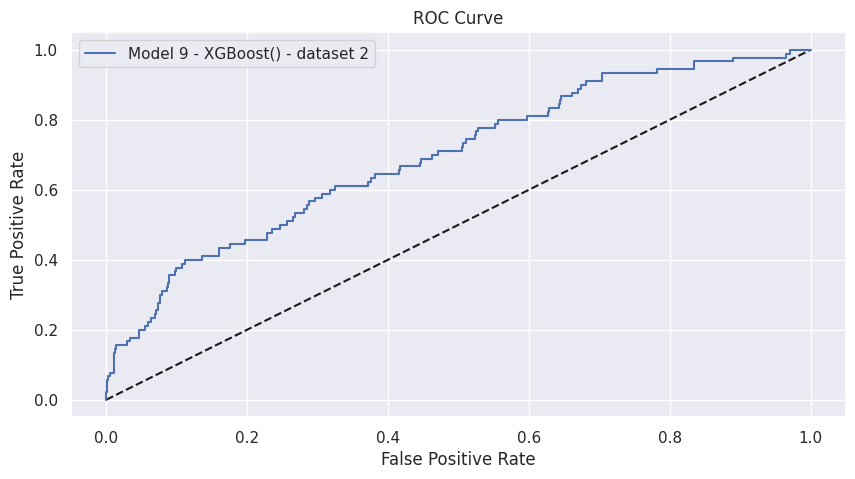

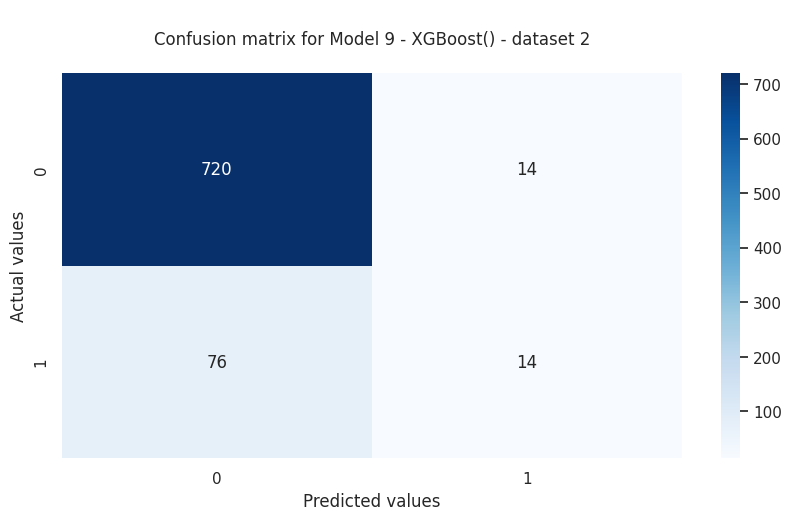

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543
9,Model 8 - XGBoost() - dataset 1,0.391892,0.765637


In [213]:
import xgboost as xgb
from xgboost import XGBClassifier

categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_2', XGBClassifier(verbosity=0))
])

xgb_param_grid_2 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_2__n_estimators': [50, 100, 150],  # You can adjust the number of estimators
    'xgb_model_2__max_depth': [3,6,12],  # You can configure the max depth
    'xgb_model_2__learning_rate': [0.1, 0.01, 0.001],  # You can configure the learning rate
    'xgb_model_2__gamma': [0.01]
}

xgb_search_2 = HalvingGridSearchCV(xgb_pipeline_2,
                                 xgb_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_2.fit(X_train_2, y_train_2)

print('\nBest hyperparameters:', xgb_search_2.best_params_)

xgb_model_2 = xgb_search_2.best_estimator_

X_test_data = X_test_2
y_test_data = y_test_2

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_2, 'Model 9 - XGBoost() - dataset 2')

In [214]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_2, X_test_2 , y_test_2 )
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0141 ± 0.0082  poutcome
0.0034 ± 0.0028  pdays
0.0007 ± 0.0012  housing
0.0002 ± 0.0039  day_of_week
0.0000 ± 0.0034  marital
     0 ± 0.0000  previous
-0.0002 ± 0.0010  campaign
-0.0005 ± 0.0019  loan
-0.0007 ± 0.0052  month_year
-0.0010 ± 0.0028  age
-0.0022 ± 0.0039  contact
-0.0027 ± 0.0032  education
-0.0032 ± 0.0029  job
None


## Model 10 - XGBoost() - zestaw 3

In [215]:
data_3.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,cons.conf.idx,emp.var.rate
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,-46.2,-1.8
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,-36.4,1.1
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,-41.8,1.4
3,38,services,married,basic.9y,admin.,admin.,telephone,fri,3,999,0,nonexistent,-41.8,1.4
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-42.0,-0.1


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'xgb_model_3__gamma': 0.01, 'xgb_model_3__learning_rate': 0.1, 'xgb_model_3__max_depth': 6, 'xgb_model_3__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       734
           1       0.66      0.34      0.45        90

    accuracy                           0.91       824
   macro avg       0.79      0.66      0.70       824
weighted avg       0.90      0.91      0.90       824



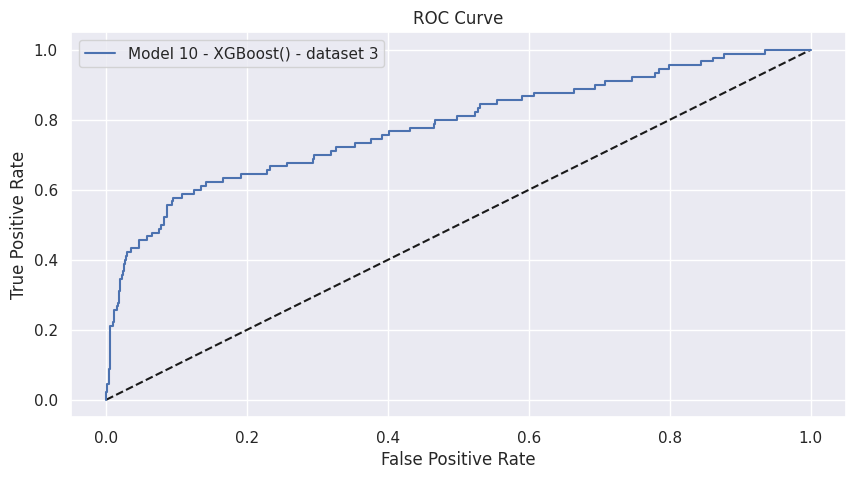

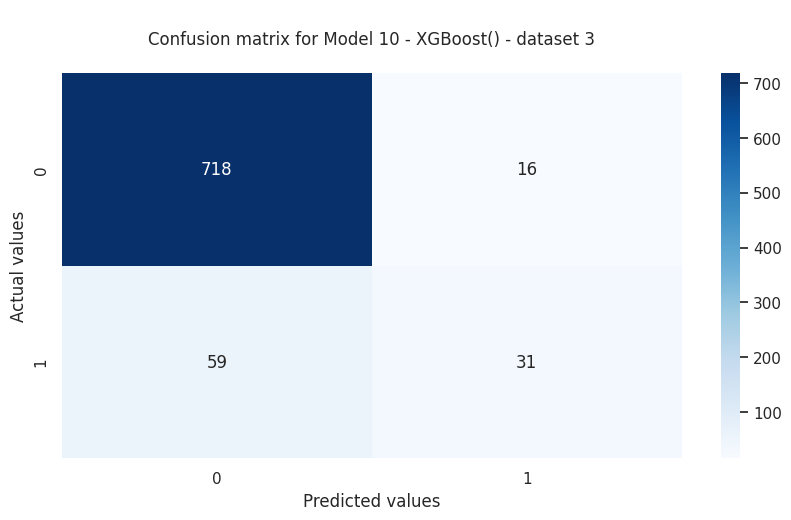

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543
9,Model 8 - XGBoost() - dataset 1,0.391892,0.765637


In [216]:


categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_3', XGBClassifier(verbosity=0))
])

xgb_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_3__n_estimators': [100],
    'xgb_model_3__max_depth': [6],
    'xgb_model_3__learning_rate': [0.1],
    'xgb_model_3__gamma': [0.01]
}

xgb_search_3 = HalvingGridSearchCV(xgb_pipeline_3,
                                 xgb_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_3.fit(X_train_3, y_train_3)

print('\nBest hyperparameters:', xgb_search_3.best_params_)

xgb_model_3 = xgb_search_3.best_estimator_

X_test_data = X_test_3
y_test_data = y_test_3

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_3, 'Model 10 - XGBoost() - dataset 3')

In [217]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_3, X_test_3 , y_test_3)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0726 ± 0.0099  emp.var.rate
0.0502 ± 0.0033  cons.conf.idx
0.0070 ± 0.0079  contact
0.0061 ± 0.0051  pdays
0.0036 ± 0.0067  marital
0.0034 ± 0.0028  age
0.0032 ± 0.0093  job
0.0029 ± 0.0045  education
0.0027 ± 0.0042  day_of_week
0.0017 ± 0.0064  campaign
0.0017 ± 0.0036  housing
0.0017 ± 0.0025  poutcome
     0 ± 0.0000  previous
-0.0002 ± 0.0028  loan
None


## Model 11 - XGBoost() - zestaw  4

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3295
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3295
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8, 'xgb_model_4__gamma': 0.01, 'xgb_model_4__learning_rate': 0.01, 'xgb_model_4__max_depth': 6, 'xgb_model_4__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       734
           1       0.42      0.44      0.43        90

    accuracy                           0.87       824
   macro avg       0.67      0.68      0.68       824
weighted avg       0.88      0.87      0.87       824



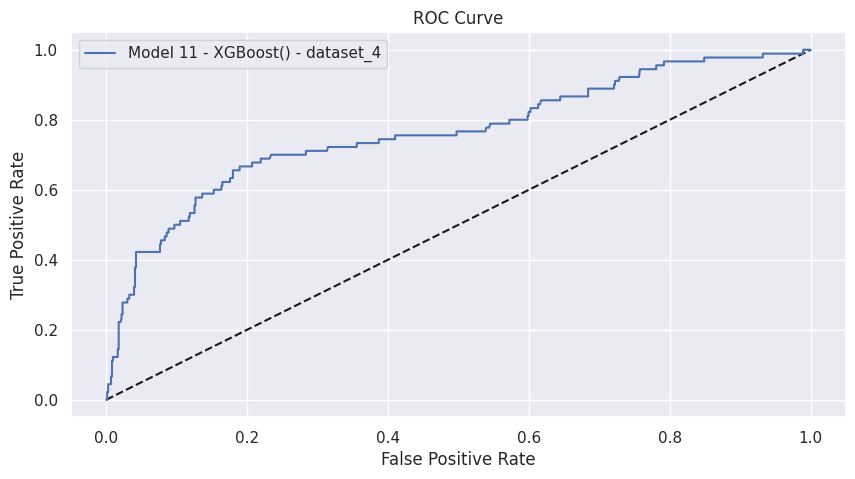

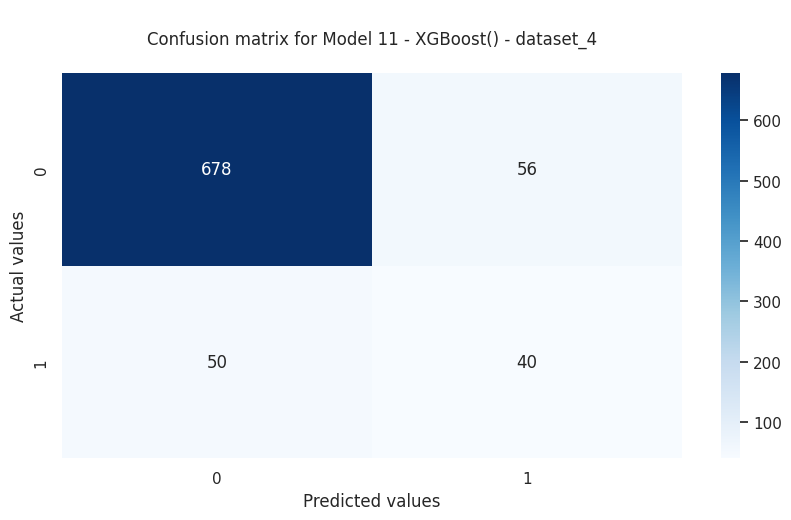

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.307692,0.691243
1,Model 0 - Baseline RFC,0.307692,0.691243
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
3,Model 2 - Logistic Regression - dataset 2,0.347107,0.761626
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
6,Model 5 - Support Vector Classiffier - dataset 2,0.369231,0.769724
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543
9,Model 8 - XGBoost() - dataset 1,0.391892,0.765637


In [218]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_4', XGBClassifier(verbosity=0))
])

xgb_param_grid_4 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_4__n_estimators': [100],
    'xgb_model_4__max_depth': [6],
    'xgb_model_4__learning_rate': [0.01],
    'xgb_model_4__gamma': [0.01]
}

xgb_search_4 = HalvingGridSearchCV(xgb_pipeline_4,
                                 xgb_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_4.fit(X_train_4, y_train_4)

print('\nBest hyperparameters:', xgb_search_4.best_params_)

xgb_model_4 = xgb_search_4.best_estimator_

X_test_data = X_test_4
y_test_data = y_test_4

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_4, 'Model 11 - XGBoost() - dataset_4')

In [219]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_4, X_test_4 , y_test_4)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0728 ± 0.0209  emp.var.rate
0.0245 ± 0.0060  cons.price.idx
0.0199 ± 0.0059  poutcome
0.0044 ± 0.0025  marital
0.0017 ± 0.0012  pdays
0.0015 ± 0.0039  day_of_week
0.0002 ± 0.0010  age
0.0002 ± 0.0028  housing
-0.0012 ± 0.0043  loan
-0.0012 ± 0.0000  previous
-0.0022 ± 0.0039  contact
-0.0029 ± 0.0029  month_year
-0.0063 ± 0.0116  education
-0.0073 ± 0.0074  campaign
-0.0080 ± 0.0079  job
None


# Wyniki zbiorcze

In [220]:
top_5_auc_models = metrics_dataframe.sort_values(by='AUC', ascending=False).head(5)
top_5_auc_models

,Model,F1_score,AUC
4,Model 3 - Logistic Regression - dataset 3,0.412451,0.812428
2,Model 1 - Logistic Regression - dataset 1,0.478873,0.808644
7,Model 6 - Support Vector Classiffier - dataset 3,0.387879,0.806010
5,Model 4 -Support Vector Classiffier - dataset 1,0.436090,0.805699
8,Model 7 - Support Vector Classiffier - dataset 4,0.423423,0.802543


In [221]:
stop

In [227]:
models = [lr_model_3, lr_model, svm_model_3, svm_model, svm_model_4]  # Add more models as needed
model_names = top_5_auc_models['Model']  # Names corresponding to the models

# Define your test datasets
X_test_data = [X_test_3, X_test,  X_test_3, X_test, X_test_4]  # datasets
y_test_data = [y_test_3, y_test,  y_test_3, y_test, y_test_4]  # Corresponding labels

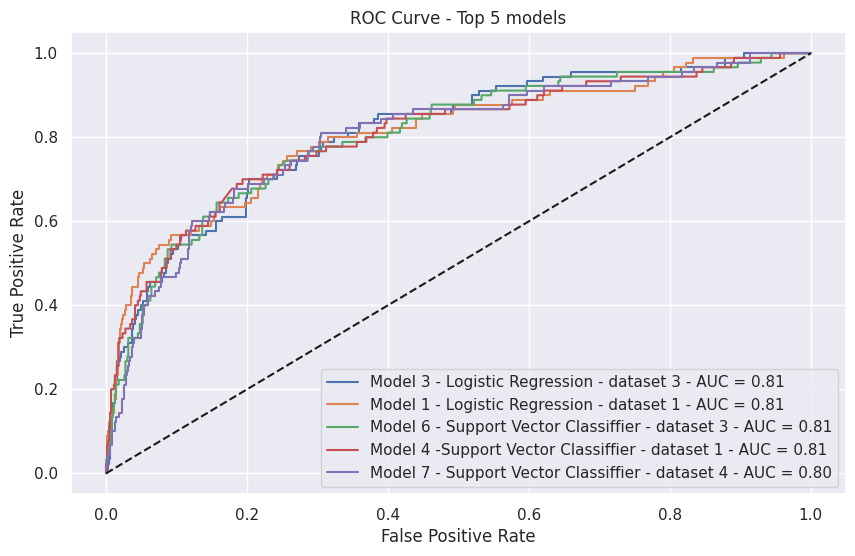

In [229]:
plt.figure(figsize=(10, 6))

for model, model_name, X_test, y_test in zip(models, model_names, X_test_data, y_test_data):
    predictions_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, predictions_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} - AUC = {auc_score:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Top 5 models')
plt.legend()
plt.show()